# Coronavirus Reverse Engineering

## Machine Learning for Genome Analysis

In a previous [notebook](./coronaversing.ipynb) we did an exploratory analysis of the data we collected from online sources and created a database of regions for each genome. The portions of the genome for each sample is classified into 3 types: ORF (a potential coding frame), UTR (untranslated regions at the 5' and 3' ends of the genome) and ING (intergenic region, located between 2 ORFs). Each portion has a label assigned, for example an UTR region could be "3UTR" or "5UTR" and ORFs could be "S", "N" or "ORF1ab", and so on, depending on which protein is codifying. The idea is to have a standardized mechanism to access regions of the genome common to all coronavirus samples to perform large scale analysis efficiently.

At this point, the labels for each region are left "undefined", since we need to execute a detailed analysis of each frame to recognize what is coding for. For example, given a coronavirus genome and the list of ORFs, how do we know which one is the ORF1a and how to join it with ORF1b to get ORF1ab? These are (usually) the first two ORFs that combined make up two thirds of the genome. Joining them it's tricker, since we have to locate the slippery sequence and perform a -1 frame shift. Sometimes there is an ORF in the 5'UTR region and the "untranslated region" now becomes potentially translatable. 

How do we know where the structural proteins coding segment are? Coronaviruses encode three conserved membrane-associated proteins that are incorporated in virions: spike (S), envelope (E), membrane (M) and a nucleoprotein (N). These four proteins seems to occur in the order S–E–M–N but between those genes, there are species-specific accessory proteins. How do we recognize these and find common sequences to classify them within a specie?

We are going to develop machine learning algorithm to automatically tag coding segments in the genome using alignment patterns of protein domains from the [Pfam](https://pfam.xfam.org/) database. 

**TABLE OF CONTENTS**

* [Machine Learning ORF Tagging Algorithm](#section1)
   * [Exploring ORF1a](#section2)
   * [Training samples (CDS)](#section3)
      - [Spike protein](#section4)
      - [Envelope protein](#section5)
      - [Membrane protein](#section6)
      - [Nucleoprotein](#section7)
      - [Accessory proteins](#section8)
   * [CDS classifier](#section9)
      - [ORF1A/ORF1B classifier](#section10)
      - [Protein classifier](#section11)

In [95]:
from matplotlib import pyplot as plt

import nglview as nv

from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image
import time

from sklearn.linear_model import LinearRegression
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import model_from_json

from reportlab.lib import colors
from reportlab.lib.units import cm

import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi

from Bio.Seq import Seq
from Bio import Entrez
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3
from Bio import Align
from Bio.SeqRecord import SeqRecord
from Bio.PDB import *

import bisect 
import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib
import pickle

from intervaltree import Interval, IntervalTree
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import datetime
import os
import subprocess
import lzma as xz

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 
cache_regions_file = ".cache_regions.pkl" 
cache_cds_orfs_file = ".cache_cds_orfs.pkl" 
cache_corona_tagged_db = ".cache_corona_tagged_db.pkl"

cache_cds_training_set = ".cache_cds_training_set.pkl" 

orf1_rf_classifier = "./models/cds_orf1_rf.pkl" 

sp_network_classifier = "./models/cds_protein_nn.h5" 
sp_network_classifier_metadata = "./models/cds_protein_nn.json" 

hidden_columns = ["sequence", "file_path"]
hidden_cds_columns = ["translation", "file_path", "location"]
hidden_regions_columns = ["id", "rna", "protein", "path"]

SLIPPERY_SEQUENCE = "UUUAAAC"

if os.path.isfile(cache_regions_file):
    corona_db = pd.read_pickle(cache_regions_file)
else:
    %run ./coronaversing.ipynb
    
if os.path.isfile(cache_vrs_file):
    corona = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
    
    # set index
    corona = corona.set_index("id")
    corona_cds = corona_cds.set_index("protein_id")
    
    # at this point we would like to analyze pretty much complete genomes
    corona_incomplete = corona[(corona["unknown"] > 0) | (corona["length"] < 27000)]
    corona_incomplete_cds = corona_cds[(corona_cds["unknown"] > 0)]

    # drop duplicates
    corona = corona[~corona.index.duplicated(keep='first')]
    corona_cds = corona_cds[~corona_cds.index.duplicated(keep='first')]
    
else:
    %run ./coronaversing.ipynb

corona_db = corona_db[~corona_db["id"].isin(corona_incomplete.index)]
corona_cds = corona_cds[~corona_cds["oid"].isin(corona_incomplete.index)]
corona_cds = corona_cds[~corona_cds.index.isin(corona_incomplete_cds.index)]

# generic function to print everything either for a protein or genome ID
def display_info(accs):
    protein_entry = corona_cds[corona_cds.index == accs]
    if len(protein_entry) > 0:   
        oid = protein_entry["oid"].values[0]
        cds = corona_cds[corona_cds["oid"] == oid]
        entry = corona[corona.index == oid]
        orfs = corona_db[corona_db["id"] == oid]
        
        display(HTML(entry.drop(hidden_columns, axis=1).to_html()))
        if len(cds) > 0 :
            display(HTML(cds.drop(hidden_cds_columns, axis=1).to_html()))
        display(HTML(orfs.drop(hidden_regions_columns, axis=1).to_html()))

        return
    
    entry = corona[corona.index == accs]
    if len(entry) > 0:
        oid = accs
        cds = corona_cds[corona_cds["oid"] == oid]
        orfs = corona_db[corona_db["id"] == oid]
        
        display(HTML(entry.drop(hidden_columns, axis=1).to_html()))
        if len(cds) > 0 :
            display(HTML(cds.drop(hidden_cds_columns, axis=1).to_html()))
        display(HTML(orfs.drop(hidden_regions_columns, axis=1).to_html()))

        return

# 1. Machine Learning ORF Tagging Algorithm <a id="section1"></a>

Before introducing machine learning concepts for protein classification, let's take a look at the data we have. This is how the current DB looks like for a given genome (we'll use NC_045512.2 as a reference). 

In [2]:
ncov = corona_db[corona_db["id"] == "NC_045512.2"]
display(HTML(ncov.drop(hidden_regions_columns, axis=1).to_html()))

,type,label,date,collection,start,end,length,unknown
rid,,,,,,,,
NC_045512.2|UTR@00000,UTR,5UTR,2020-03-13,Dec-2019,0,265,265,0.0
NC_045512.2|ORF@00265,ORF,UNDEF,2020-03-13,Dec-2019,265,13483,13218,0.0
NC_045512.2|ING@13483,ING,UNDEF,2020-03-13,Dec-2019,13483,13767,284,0.0
NC_045512.2|ORF@13767,ORF,UNDEF,2020-03-13,Dec-2019,13767,21555,7788,0.0
NC_045512.2|ORF@21535,ORF,UNDEF,2020-03-13,Dec-2019,21535,25384,3849,0.0
NC_045512.2|ORF@25331,ORF,UNDEF,2020-03-13,Dec-2019,25331,25448,117,0.0
NC_045512.2|ORF@25392,ORF,UNDEF,2020-03-13,Dec-2019,25392,26220,828,0.0
NC_045512.2|ORF@26182,ORF,UNDEF,2020-03-13,Dec-2019,26182,26281,99,0.0
NC_045512.2|ORF@26244,ORF,UNDEF,2020-03-13,Dec-2019,26244,26472,228,0.0


As you might guess, ORF@00265 and ORF@13767 are ORF1a (\~13.2kbp) and ORF1b (\~7.7kpb). Ideally, we would like to remove ORF1b from our database and replace it with ORF1ab, since that is consistent to what happens in reality : the first gene is translated as ORFs 1a and 1ab, with 1ab resulting from a pseudoknot-induced -1 ribosomal frame shifting event at a slippery sequence of UUUAAAC at the ORF1a/ORF1b junction, which we will have to find to get the correct aminoacid sequence of the 1ab polyprotein which it's around ~21kbp.

The first open reading frame ORF@21535 downstream ORF1ab encodes the spike (S) glycoprotein and the size it's around ~3.8 kbps. E, M and N are encoded by ORF@26244, ORF@26522 and ORF@28273 respectively. We know this because the genbank [entry](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2) at NCBI contains annotations with the name of each CDS. This annotations aren't always available, so we should develop a method to generically tag each coding region with the protein it codifies.

Besides the polyprotein and the structural proteins there are a few other coding segments which we are going to deal later.

## 1.1 Exploring ORF1a <a id="section2"></a>

By looking at ORF1 on the sample above, seems natural to apply the following algorithm over our entire database.

* Find the 2 biggest ORFs on the genome. The bigger one is ORF1a and the other is ORF1b.
* Whatever it's on the left of ORF1a it's 5UTR (regardless if there are any additional ORFs on that region).
* We have to find the slippery sequence near the end of ORF1a and perform the frame shift to get the aminoacid sequence of ORF1ab. 

Before going there, let's plot the distribution of the biggest ORF for each genome to spot for anomalies.

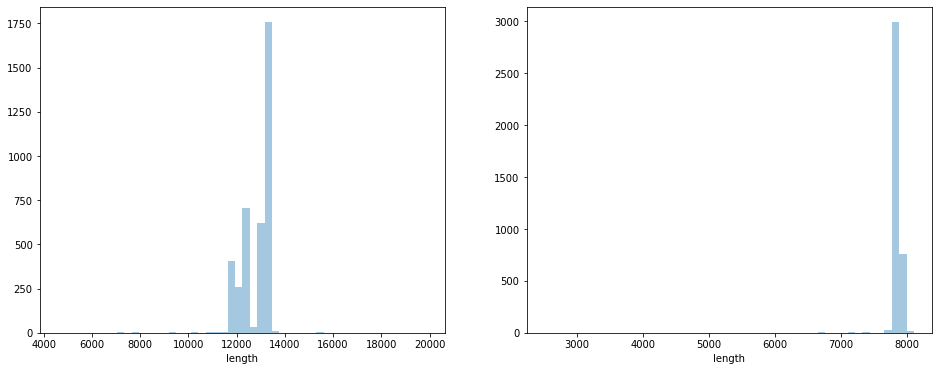

In [3]:
putative_orf1a = corona_db.groupby("id")["length"].max()
putative_orf1b = corona_db.groupby("id")["length"].apply(lambda x: x.nlargest(2).min())

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(putative_orf1a, kde=False, ax=axs[0]);
sns.distplot(putative_orf1b, kde=False, ax=axs[1]);

# do some stats
mean_orf1a = putative_orf1a.mean()
std_orf1a = putative_orf1a.std()
mean_orf1b = putative_orf1b.mean()
std_orf1b = putative_orf1b.std()

In [4]:
print("[+] ORF1a mean size = %.2f bp" % mean_orf1a)
print("[+] ORF1b mean size = %.2f bp" % mean_orf1b)
print("[+] ORF1a std = %.2f bp" % std_orf1a)
print("[+] ORF1b std = %.2f bp" % std_orf1b)

[+] ORF1a mean size = 12796.02 bp
[+] ORF1b mean size = 7836.15 bp
[+] ORF1a std = 640.88 bp
[+] ORF1b std = 207.69 bp


The average size of both ORFs are consistent with the information available about the virus. But it's clear from the histogram that there are quite a few outliers. Let's set the lower limit for the gene size to 3 standard deviations.

In [5]:
lower_limit_orf1a = mean_orf1a - 3 * std_orf1a
lower_limit_orf1b = mean_orf1b - 3 * std_orf1b

outliers_orf1a = putative_orf1a[putative_orf1a < lower_limit_orf1a]
outliers_orf1b = putative_orf1b[putative_orf1b < lower_limit_orf1b]

print("[+] Total of outliers (orf1a) :", len(outliers_orf1a))
print("[+] Total of outliers (orf1b) :", len(outliers_orf1b))

[+] Total of outliers (orf1a) : 21
[+] Total of outliers (orf1b) : 27


So what's going on with this samples? Let's see how many belongs to both groups of outliers. Those are definitely fishy samples.

In [6]:
fishy_samples = list(set(outliers_orf1b.index).intersection(outliers_orf1a.index))
display(HTML(corona.loc[fishy_samples].drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,unknown,country,host,strain,collection_date
id,,,,,,,,,
AY351680.1,29749,2003-08-03,1.183152,"SARS coronavirus ZMY 1, complete genome",0.0,unknown,unknown,unknown,unknown
AY297028.1,29715,2003-05-19,1.188213,"SARS coronavirus ZJ01, complete genome",0.0,unknown,unknown,unknown,unknown
MH687975.1,27254,2018-11-12,1.293996,"Betacoronavirus sp. strain VZ_BetaCoV_22054_56, partial genome",0.0,viet nam,rattus argentiventer,VZ_BetaCoV_22054_56,09-Dec-2013
AY613948.1,29730,2005-02-28,1.189343,"SARS coronavirus PC4-13, complete genome",0.0,china,palm civet,unknown,unknown
MN486588.1,27933,2020-02-10,1.261989,"Porcine epidemic diarrhea virus strain Ah2016f2, complete genome",0.0,china,porcine,Ah2016f2,Feb-2016
FN430415.1,27593,2013-07-03,1.285347,"Infectious bronchitis virus NGA/A116E7/2006, complete genome",0.0,nigeria,unknown,unknown,2006
HM776941.1,28580,2012-10-11,1.244400,"Transmissible gastroenteritis virus isolate AYU, complete genome",0.0,china,swine,unknown,2009
AY613949.1,29730,2005-02-28,1.188213,"SARS coronavirus PC4-136, complete genome",0.0,china,palm civet,unknown,unknown
AY613947.1,29730,2005-02-28,1.187648,"SARS coronavirus GZ0402, complete genome",0.0,china,unknown,unknown,unknown


A lot of samples are  old and seems like they might be quite different from the reference genome of SARA-CoV-2 we are looking. I think it's safe to remove this samples from our database. We should get the starting point for each ORF1a sequence and whatever is on the left we should define it as a 5UTR region. What is the distribution of the value for the starting codon of ORF1a? 

[+] ORF1a start mean = 299.13 bp
[+] ORF1a start std = 535.05 bp


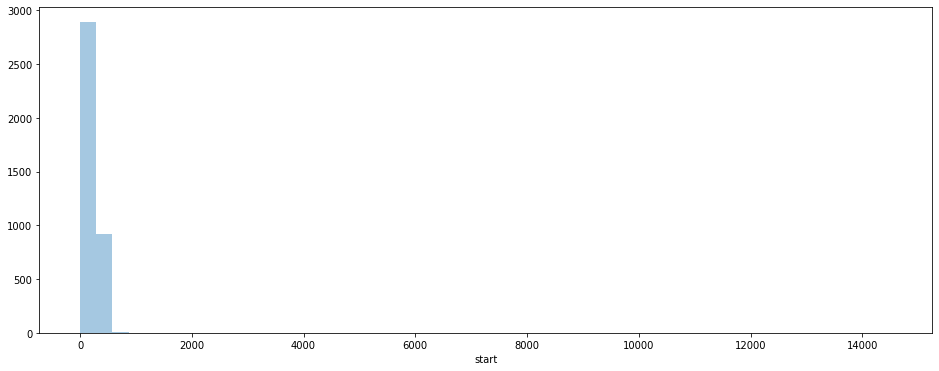

In [7]:
plt.figure(figsize=(16, 6))
orf1a = corona_db.sort_values("length", ascending=False).drop_duplicates(["id"],keep="first")

# get start codons
orf1a_start = orf1a["start"]
sns.distplot(orf1a_start, kde=False);

# do some stats
mean_start_orf1a = orf1a_start.mean()
std_start_orf1a = orf1a_start.std()

print("[+] ORF1a start mean = %.2f bp" % mean_start_orf1a)
print("[+] ORF1a start std = %.2f bp" % std_start_orf1a)

Again, there are a few outliers with starting codons way further from the average one which is \~280bp downstream the 5' end of the genome. We should define a cutoff (3 sigma) for this value and inspect the outliers .

In [8]:
start_orf1a = mean_start_orf1a + 3 * std_start_orf1a
outliers_orf1a = orf1a[orf1a["start"] > start_orf1a]

display(HTML(outliers_orf1a.drop(hidden_regions_columns, axis=1).to_html()))
print("[+] Total ORF1a outliers (based on the starting codon) :", len(outliers_orf1a))

,type,label,date,collection,start,end,length,unknown
rid,,,,,,,,
AY559088.1|ORF@02613,ORF,UNDEF,2004-09-24,unknown,2613,13398,10785,0.0
AY595412.1|ORF@02921,ORF,UNDEF,2006-12-07,unknown,2921,13391,10470,0.0
GU937797.1|ORF@02385,ORF,UNDEF,2011-03-27,unknown,2385,12639,10254,0.0
AY394850.2|ORF@03360,ORF,UNDEF,2005-05-10,unknown,3360,13413,10053,0.0
MN486588.1|ORF@04008,ORF,UNDEF,2020-02-10,Feb-2016,4008,12618,8610,0.0
FN430415.1|ORF@12427,ORF,UNDEF,2013-07-03,2006,12427,20386,7959,0.0
AY613948.1|ORF@13548,ORF,UNDEF,2005-02-28,unknown,13548,21435,7887,0.0
AY613949.1|ORF@13548,ORF,UNDEF,2005-02-28,unknown,13548,21435,7887,0.0
HM776941.1|ORF@12528,ORF,UNDEF,2012-10-11,2009,12528,20364,7836,0.0


[+] Total ORF1a outliers (based on the starting codon) : 12


Is even 3 sigma a good measure of what an anomaly is suppose to be on this context? Looking at the cases on the table it just seems that this viruses contains an ORF1a gene much further from the 5' that others normally do. Is the ORF size and start position enough variables to predict which specific ORF is? My guess is that the aminoacid composition of the translated segment should play an important role as well.

When this type of problems arise, i.e. multiple variables are needed in order to spot anomalies and classify certain data, that's where machine learning comes handy. 

So let's give it a try. But before we have to craft our training dataset and we can use the CDS annotations for that.

## 1.2 Training samples (CDS) <a id="section3"></a>

We already have samples with the ORF1A and ORF1B gene tagged as CDS annotations and we can use those to build the training set for our algorithm. Let's see how many samples we have for each case.

In [9]:
# get everything with a reference to 1a
orf1a_cds = corona_cds[(corona_cds["type"] == "CDS") & ((corona_cds["gene"].str.contains("1A")) | 
                                                        (corona_cds["product"].str.contains("1a")))]

# remove orf1ab rows
orf1a_cds = orf1a_cds.drop(orf1a_cds[orf1a_cds["product"].str.contains("orf1ab")].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("1ab")].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("orf1a/1b")].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1A/B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1A/1B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF 1A/1B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1AB"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "PP1AB"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "1AB"].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("orf1a/b")].index)

# get everything with a reference to 1b
orf1b_cds = corona_cds[(corona_cds["type"] == "CDS") & ((corona_cds["gene"].str.contains("1B")) | 
                                                        (corona_cds["product"].str.contains("1b")))]

# remove orf1ab rows
orf1b_cds = orf1b_cds.drop(orf1b_cds[orf1b_cds["product"].str.contains("orf1ab")].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("1ab")].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("orf1a/1b")].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1A/B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1A/1B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF 1A/1B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1AB"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "PP1AB"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "1AB"].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("orf1a/b")].index)

print("[+] ORF1A tagged cases :", len(orf1a_cds))
print("[+] ORF1B tagged cases :", len(orf1b_cds))

[+] ORF1A tagged cases : 898
[+] ORF1B tagged cases : 175


Of more than 5k samples we only have around 1k of genomes with ORF1A tagged and 10 times less with ORF1B tagged. It's a quite an unbalanced dataset, the good thing about RF is that we can easily deal with that by weighting each sample.

Let's plot the distribution of the start and end position of both of this ORFs to make sure we are not including some weird anomaly.

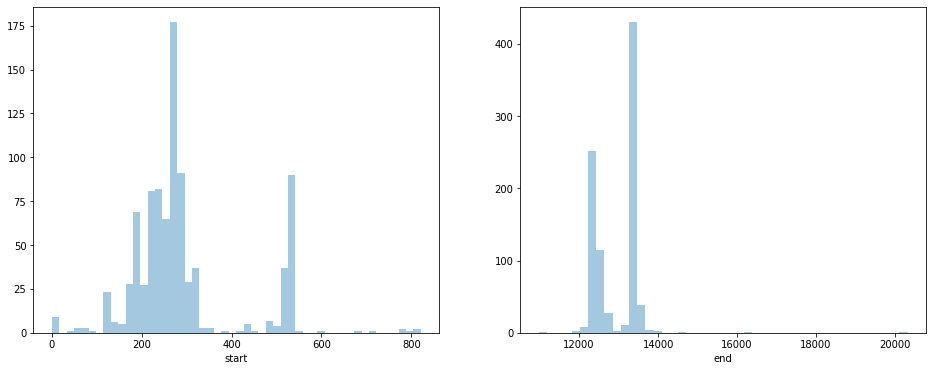

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_cds["start"], kde=False, ax=axs[0]);
sns.distplot(orf1a_cds["end"], kde=False, ax=axs[1]);

In [11]:
orf1a_outliers = orf1a_cds[orf1a_cds["end"] > 15000]
display(HTML(orf1a_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ACV87243.1,polyprotein 1a,unknown,1,GQ427173.1,CDS,25-FEB-2010,531,20321,19791,0.0
AXP11706.1,polyprotein 1a,ORF1A,1,MF685025.1,CDS,26-AUG-2018,820,16288,15468,0.0


There is definitely a typo on sample [GQ427173.1](https://www.ncbi.nlm.nih.gov/nuccore/MG752895.1). The CDS annotation that is suppose to be the polyprotein 1ab it's tagged as 1a and viceversa. The rest looks OK after manual inspection of the genbank entries. We can safely set a cutoff of 19k for the size of the ORF1A gene. 

In [12]:
orf1a_outliers = orf1a_cds[orf1a_cds["length"] > 19000]
orf1a_cds = orf1a_cds[~orf1a_cds.index.isin(orf1a_outliers.index)]
print("[+] ORF1A final samples :", len(orf1a_cds))

[+] ORF1A final samples : 897


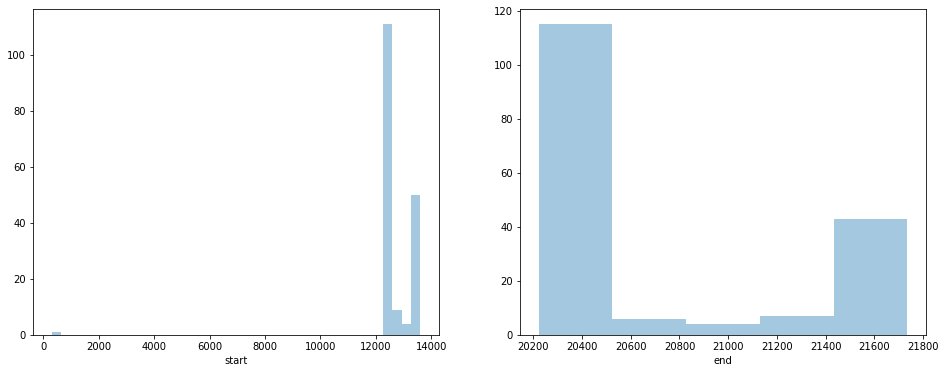

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1b_cds["start"], kde=False, ax=axs[0]);
sns.distplot(orf1b_cds["end"], kde=False, ax=axs[1]);

Let's look at the outliers for ORF1B.

In [14]:
orf1b_outliers = orf1b_cds[orf1b_cds["start"] < 10000]
display(HTML(orf1b_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AQT33893.1,polyprotein,ORF1B,1,KX550281.1,CDS,04-MAR-2017,292,20637,20388,0.0


The KX550281.1 case definitely looks like a typo; by inspecting the [genbak entry](https://www.ncbi.nlm.nih.gov/nuccore/KX550281.1) this it's actually an ORF1AB gene, not ORF1B. We should remove this samples from our training dataset.

In [15]:
orf1b_cds = orf1b_cds[~orf1b_cds.index.isin(orf1b_outliers.index)]
print("[+] ORF1B final samples :", len(orf1b_cds))

[+] ORF1B final samples : 174


Finally, let's plot the length distribution of both ORFs to have an idea of the average size of each one.

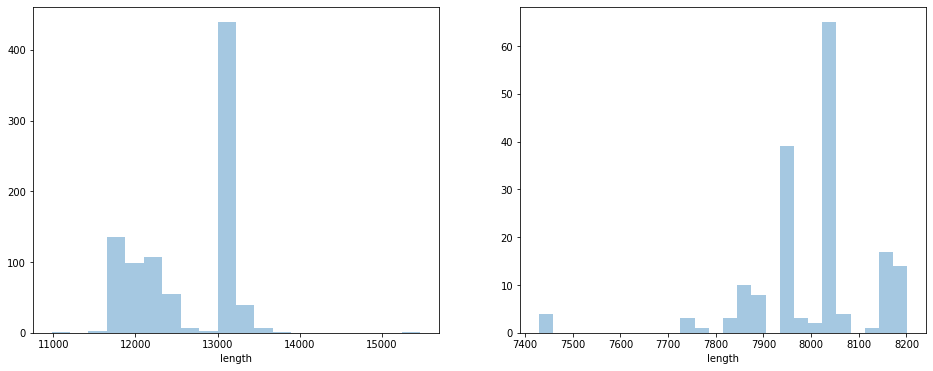

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_cds["length"], kde=False, ax=axs[0]);
sns.distplot(orf1b_cds["length"], kde=False, ax=axs[1]);

Pretty good, so now we can safely set a cutoff for the size range of each type of ORF to avoid pollution of our dataset (since they don't overlap and are the biggest genes on the genome) 

In [17]:
# range for ORF1A gene
min_orf1a_size = orf1a_cds["length"].min()
max_orf1a_size = orf1a_cds["length"].max()

# range for ORF1B gene
min_orf1b_size = orf1b_cds["length"].min()
max_orf1b_size = orf1b_cds["length"].max()

print("[+] ORF1A (min, max) :", min_orf1a_size, "-", max_orf1a_size)

print("[+] ORF1B (min, max) :", min_orf1b_size, "-", max_orf1b_size)

orf1a_cds = corona_cds[(corona_cds["length"] >= min_orf1a_size) & (corona_cds["length"] <= max_orf1a_size)]
orf1b_cds = corona_cds[(corona_cds["length"] >= min_orf1b_size) & (corona_cds["length"] <= max_orf1b_size)]

print("[+] ORF1A final samples :", len(orf1a_cds))
print("[+] ORF1B final samples :", len(orf1b_cds))

[+] ORF1A (min, max) : 10978 - 15468
[+] ORF1B (min, max) : 7428 - 8202
[+] ORF1A final samples : 1296
[+] ORF1B final samples : 191


So now we have our ORF1 CDS that we are going to use as part of the training set. Let's get the remaining CDS.

In [18]:
not_orf1_cds = corona_cds[(~corona_cds.index.isin(orf1b_cds.index)) & 
                          (~corona_cds.index.isin(orf1a_cds.index))]

Ideally we would like to clean up this data set from ORF1AB frames, since those are not going to be classified. Let's plot the length distribution of the remaining ORF to find a cutoff size for those cases.

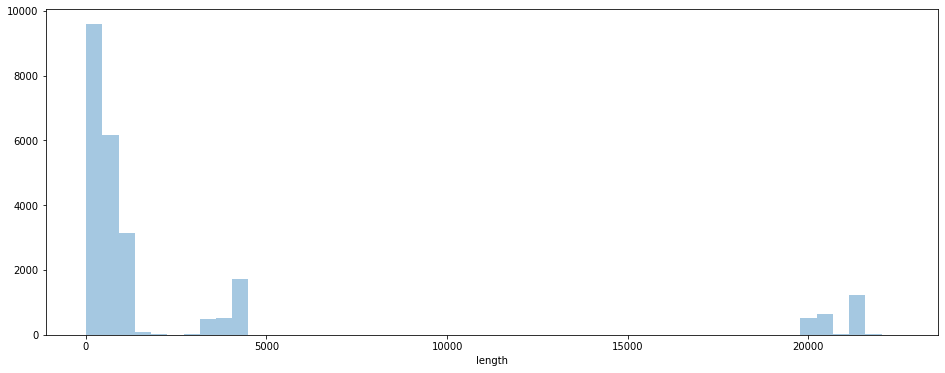

In [19]:
plt.figure(figsize=(16, 6))
sns.distplot(not_orf1_cds["length"], kde=False);

So yes, there is a pretty clear separation between ORF1ABs from the others.

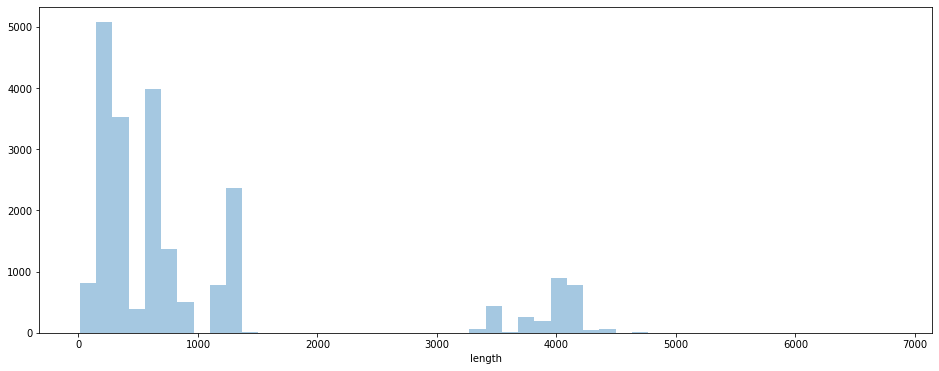

In [20]:
orf1ab = not_orf1_cds[not_orf1_cds["length"] > 15000]
not_orf1_cds = not_orf1_cds[(not_orf1_cds["type"] == "CDS") & (not_orf1_cds["length"] < 15000)]
plt.figure(figsize=(16, 6))
sns.distplot(not_orf1_cds["length"], kde=False);

In [21]:
not_orf1_outliers = not_orf1_cds[not_orf1_cds["length"] > 5000]
display(HTML(not_orf1_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18658.1,replicase polyprotein,unknown,1,MH687975.1,CDS,12-NOV-2018,11663,18467,6804,0.0


That case really looks like an ORF1B frame, so we should better move it to the other dataframe and remove it from here.

In [22]:
orf1b_cds = pd.concat([orf1b_cds, not_orf1_outliers])
not_orf1_cds = not_orf1_cds[(~not_orf1_cds.index.isin(not_orf1_outliers.index))]
orf1b_cds = orf1b_cds.groupby(orf1b_cds.index).first()

print("[+] ORF remaining samples :", len(not_orf1_cds))

[+] ORF remaining samples : 21599


Now it's time to extract the structural proteins's CDS, which are S, HE, E, M and N. After inspection, most of the time this CDS have a single letter gene name for each case.

In [23]:
corona_cds_orfs = {}

# some strings to filter out potential structures proteins from CDS
product_strings = {"S"  : ["spike", "s protein", "e2 glycoprotein", "surface glycoprotein"], 
                   "HE" : ["hemagglutinin", "he protein", "protein he", "hemmaglutinin"],                    
                   "E"  : ["envelope", " e protein", "envelop protein", "enveloppe"], 
                   "M"  : ["m protein", "membrane m", "membrane protein", "membrane glycoprotein"],
                   "N"  : ["nucleocapsid", "nucloecapsid"]}

structural_proteins_ids = []
for sp in ["S", "E", "M", "N", "HE"]:
    cds_filter = (not_orf1_cds["gene"] == sp) | (not_orf1_cds["product"] == sp.lower())
    
    # special case for E gene 
    if sp == "E":
        cds_filter = cds_filter | (not_orf1_cds["product"] == "e protein")

    if sp == "M":
        cds_filter = cds_filter | (not_orf1_cds["product"] == "protein m") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "membrane") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "matrix glycoprotein") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "matrix protein") 

    if sp == "N":
        cds_filter = cds_filter | (not_orf1_cds["product"] == "nucleopcapsid n protein") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "nucelocapsid") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "capsid") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "nucleoprotein") 
        cds_filter = cds_filter | (not_orf1_cds["product"] == "n protein") 

    for val in product_strings[sp]:
        cds_filter = cds_filter | not_orf1_cds["product"].str.contains(val) | (not_orf1_cds["product"] == val)
    corona_cds_orfs[sp] = not_orf1_cds[cds_filter]
    structural_proteins_ids += list(corona_cds_orfs[sp].index)

# let's account for the rest as accessory proteins
accessory_cds = not_orf1_cds[(~not_orf1_cds.index.isin(structural_proteins_ids))]

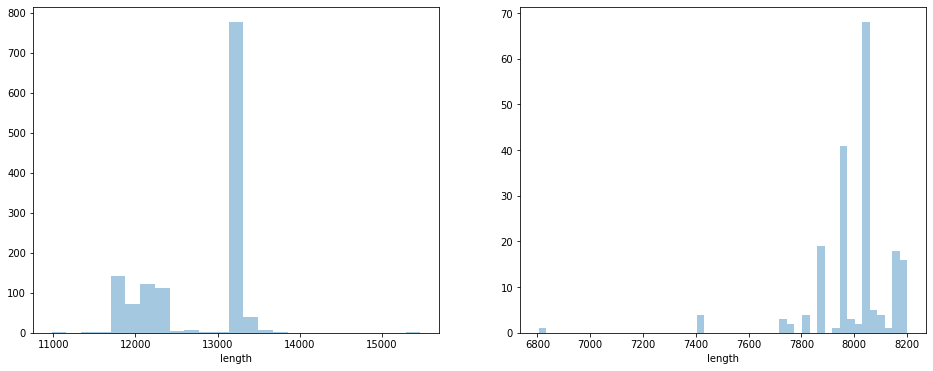

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_cds["length"], kde=False, ax=axs[0]);
sns.distplot(orf1b_cds["length"], kde=False, ax=axs[1]);

I'm sure the string search query we did on the product description of the CDS above polluted our dataset in both ways; we probably missed a few structural proteins from the CDS database and we got some incorrect ones. Let's plot the start, end and size distribution for each structural protein to spot for anomalies.

### 1.1.1 Spike protein <a id="section4"></a>

Let's start with the "S" protein CDS.

In [96]:
parser = MMCIFParser()
structure = parser.get_structure("5xlr", "./data/rcsb/coronaviridae/5xlr.cif")
view = nv.show_biopython(structure)
view

NGLWidget()

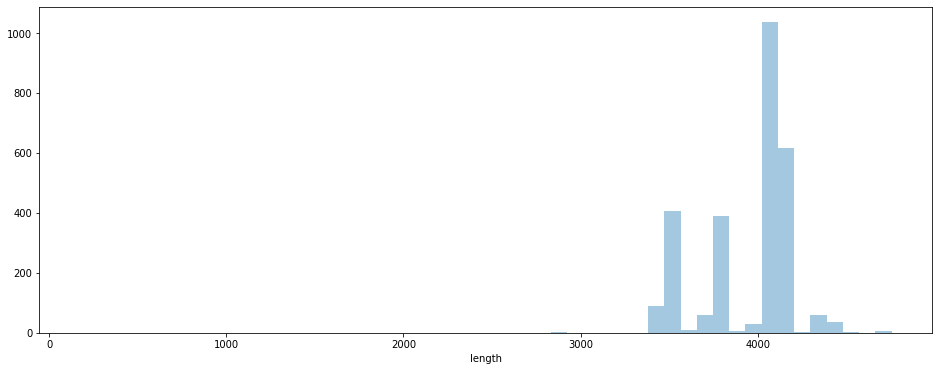

In [26]:
plt.figure(figsize=(16, 6))
sns.distplot(corona_cds_orfs["S"]["length"], kde=False);

In [27]:
min_s_size = 3300
max_s_size = 4500

outliers_s_cds = corona_cds_orfs["S"][(corona_cds_orfs["S"]["length"] <= min_s_size) | 
                                      (corona_cds_orfs["S"]["length"] >= max_s_size)]

display(HTML(outliers_s_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ALK28793.1,spike glycoprotein,unknown,1,KT253272.1,CDS,26-OCT-2015,20588,25337,4749,0.0
AUS29611.1,spike glycoprotein,S,1,MG752895.1,CDS,27-JAN-2018,25522,28402,2880,0.0
AMQ49004.1,truncated s protein,S,1,KU710265.1,CDS,12-AUG-2016,21433,23839,2406,0.0
BAU21412.1,spike glycoprotein,S,1,LC088095.1,CDS,05-JAN-2016,20808,25563,4755,0.0
BAU21406.1,spike glycoprotein,S,1,LC088094.1,CDS,05-JAN-2016,20817,25572,4755,0.0
AAT70074.1,spike protein,unknown,1,AY641576.1,CDS,13-NOV-2007,23798,23972,174,0.0
AVM87347.1,spike protein,unknown,1,MG600030.1,CDS,08-NOV-2018,23088,26025,2937,0.0
AXP11708.1,spike glycoprotein,S,1,MF685025.1,CDS,26-AUG-2018,23200,25969,2769,0.0
AIU41585.1,spike glycoprotein,S,1,KM403390.1,CDS,30-JAN-2015,20825,25547,4722,0.0


This looks pretty good, except for one that's definitely some kind of typo. Also there are a few truncated proteins and by looking at the entries and the papers related these are novel variants of the virus (see [this](https://www.ncbi.nlm.nih.gov/pubmed/27486688) and [this](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0205209)). We'll leave this samples to take into account changes in the protein that might appear in the wild.

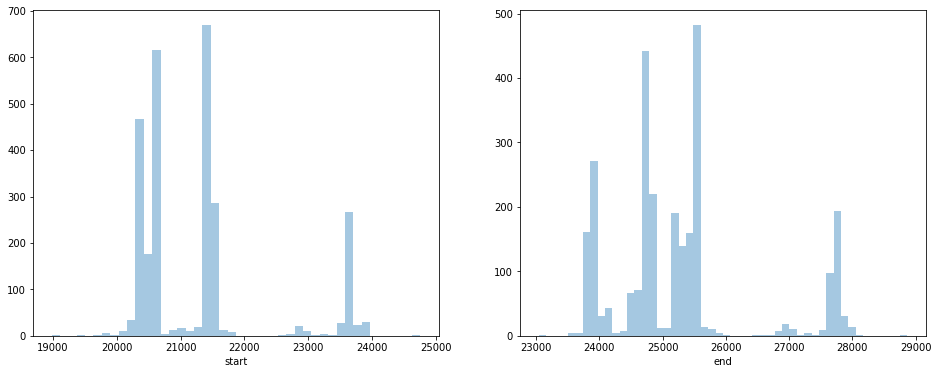

In [28]:
outliers_s_cds = corona_cds_orfs["S"][(corona_cds_orfs["S"]["length"] <= min_s_size)]
corona_cds_orfs["S"] = corona_cds_orfs["S"][(~corona_cds_orfs["S"].index.isin(outliers_s_cds.index))]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_cds_orfs["S"]["start"], kde=False, ax=axs[0]);
sns.distplot(corona_cds_orfs["S"]["end"], kde=False, ax=axs[1]);

In [29]:
max_s_size = 25000

outliers_s_cds = corona_cds_orfs["S"][(corona_cds_orfs["S"]["start"] >= max_s_size)]

if(len(outliers_s_cds) > 0):
    display(HTML(outliers_s_cds.drop(hidden_cds_columns, axis=1).to_html()))

The start/end CDS codon distribution looks pretty good, they don't overlap and are in the expected range. The only outlier is related to the novel variant we mentioned above. Let's print one of each product to make sure we are not including other CDS.

In [30]:
one_of_each_s_protein = corona_cds_orfs["S"].drop_duplicates("product")
display(HTML(one_of_each_s_protein.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AST13215.1,spike protein,S,1,KX839246.1,CDS,07-SEP-2017,20620,24763,4143,0.0
ANF29217.1,s protein,S,1,KX154689.1,CDS,30-APR-2017,21433,25495,4062,0.0
AQN78768.1,spike glycoprotein,S,1,KX538978.1,CDS,18-FEB-2017,23639,27716,4077,0.0
AJO27013.1,surface glycoprotein,S,1,KP143511.1,CDS,23-FEB-2015,20163,24564,4401,0.0
AIG54295.1,spike (s) glycoprotein,unknown,1,KF931628.1,CDS,25-MAR-2015,20345,23822,3477,0.0
AEA10398.1,spike glycoprotein precursor,unknown,1,HQ890526.1,CDS,26-SEP-2014,21451,25219,3768,0.0
AID16631.1,spike structural protein,unknown,1,KF294357.1,CDS,25-AUG-2015,23375,27449,4074,0.0
AXX83309.1,spike surface glycoprotein,S,1,MG197711.1,CDS,16-SEP-2018,23551,27640,4089,0.0
AHI85760.1,s,unknown,1,KF853202.1,CDS,16-FEB-2014,20370,23868,3498,0.0


Let's remove the "e2 glycoprotein" entries we have.

In [31]:
e2_glycoprotein = corona_cds_orfs["S"][corona_cds_orfs["S"]["product"].str.contains("e2 glycoprotein")]
corona_cds_orfs["S"] = corona_cds_orfs["S"][(~corona_cds_orfs["S"].index.isin(e2_glycoprotein.index))]

We should also try to cleanup the accessory proteins dataframe from S proteins that might be polluting the data.

In [32]:
s_protein_size_min = corona_cds_orfs["S"]["length"].min()
s_protein_size_max = corona_cds_orfs["S"]["length"].max()


polluted_s_cds = accessory_cds[(accessory_cds["length"] >= s_protein_size_min) & 
                               (accessory_cds["length"] <= s_protein_size_max)]

if len(polluted_s_cds) == 0:
    print("[+] All covered")
else:
    display(HTML(polluted_s_cds.drop(hidden_cds_columns, axis=1).to_html()))
    
print("[+] Do we have duplicates?", not(len(corona_cds_orfs["S"]["oid"].unique()) == len(corona_cds_orfs["S"])))

[+] All covered
[+] Do we have duplicates? False


[Hemagglutinin-esterases](https://en.wikipedia.org/wiki/Hemagglutinin_esterase) are also other type of structural proteins coded by coronaviruses that we captured in our dataframe. Let's take a look at the distribution of the protein's size.

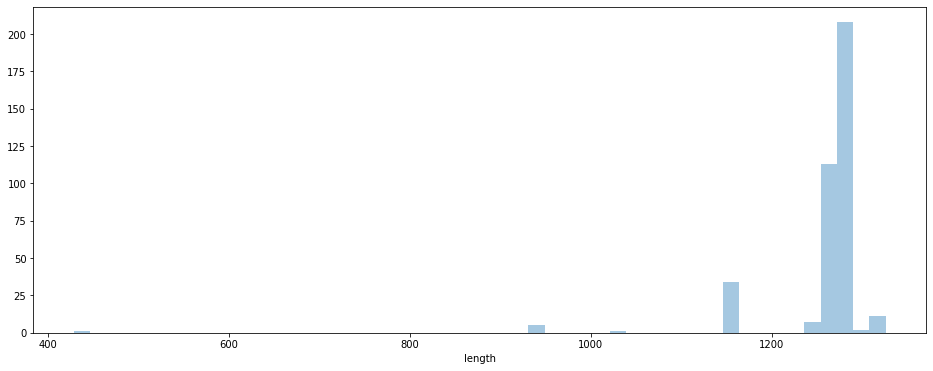

In [33]:
plt.figure(figsize=(16, 6))
sns.distplot(corona_cds_orfs["HE"]["length"], kde=False);

In [34]:
min_s_size = 900
max_s_size = 1500

outliers_he_cds = corona_cds_orfs["HE"][(corona_cds_orfs["HE"]["length"] <= min_s_size) | 
                                        (corona_cds_orfs["HE"]["length"] >= max_s_size)]

display(HTML(outliers_he_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AWV66925.1,truncated non-functional hemagglutinin esterase,HE,1,MG996765.1,CDS,24-JUN-2018,26843,27272,429,0.0


We'll remove the outliers for this case.

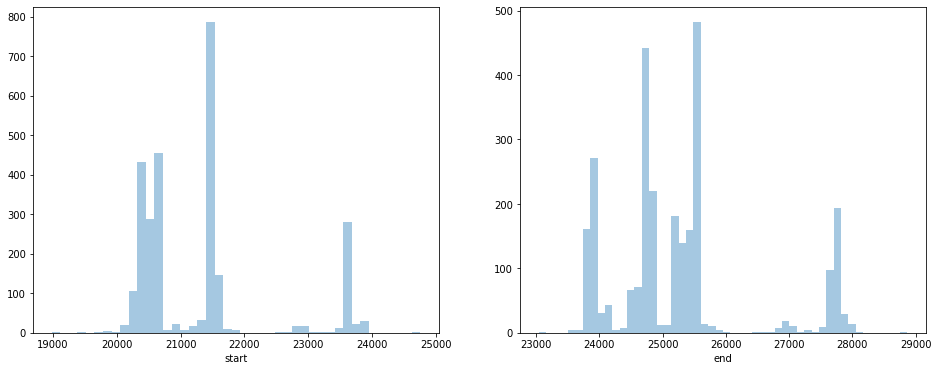

In [35]:
corona_cds_orfs["HE"] = corona_cds_orfs["HE"][(~corona_cds_orfs["HE"].index.isin(outliers_he_cds.index))]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_cds_orfs["S"]["start"], kde=False, ax=axs[0]);
sns.distplot(corona_cds_orfs["S"]["end"], kde=False, ax=axs[1]);

In [36]:
one_of_each_he_protein = corona_cds_orfs["HE"].drop_duplicates("product")
display(HTML(one_of_each_he_protein.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AQN78767.1,hemagglutinin-esterase,HE,1,KX538978.1,CDS,18-FEB-2017,22353,23625,1272,0.0
AVI15032.1,hemagglutinin esterase,HE,1,MG757141.1,CDS,05-FEB-2019,22334,23609,1275,0.0
BBM61476.1,hemagglutinin-esterase glycoprotein,HE,1,LC494182.1,CDS,08-FEB-2020,22315,23590,1275,0.0
AHN64773.1,hemagglutinin-esterase protein,HE,1,KF906249.1,CDS,02-APR-2014,22355,23630,1275,0.0
AID16630.1,hemmaglutinin-esterase,unknown,1,KF294357.1,CDS,25-AUG-2015,22082,23360,1278,0.0
ARA15420.1,hemagglutinin-neuraminidase,unknown,1,KY684759.1,CDS,21-FEB-2020,22315,23599,1284,0.0
AFD97612.1,he,unknown,1,JQ173883.1,CDS,24-MAR-2012,22605,23925,1320,0.0
QEY10640.1,he protein,unknown,1,MN514964.1,CDS,07-OCT-2019,22336,23611,1275,0.0
AAA66393.1,hemagglutinin-esterase precursor,HE,1,U00735.2,CDS,23-APR-2003,22351,23626,1275,0.0


### 1.1.2 Envelop protein <a id="section5"></a>

Now let's look at the E protein.

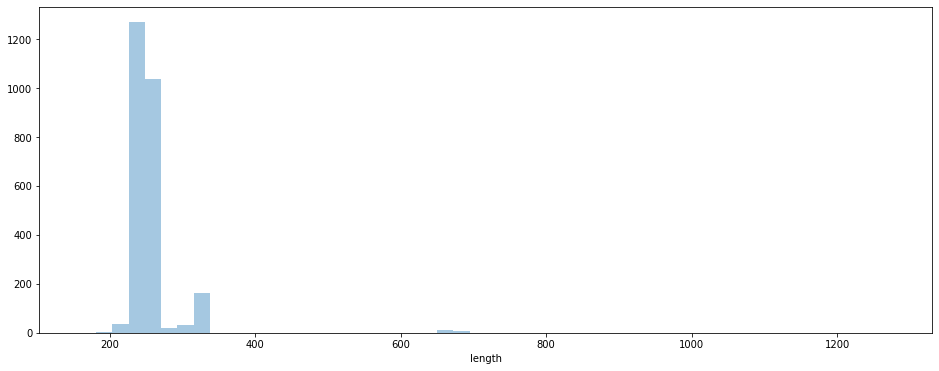

In [37]:
plt.figure(figsize=(16, 6))
sns.distplot(corona_cds_orfs["E"]["length"], kde=False);

In [38]:
min_e_size = 100
max_e_size = 400

outliers_e_cds = corona_cds_orfs["E"][(corona_cds_orfs["E"]["length"] <= min_e_size) | 
                                      (corona_cds_orfs["E"]["length"] >= max_e_size)]

if len(outliers_e_cds) > 0:
    display(HTML(outliers_e_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ALT66875.1,envelope protein,E,1,KU242423.1,CDS,27-DEC-2015,27846,28506,660,0.0
AAR87538.1,putative envelope protein m,unknown,1,AY502926.1,CDS,25-FEB-2004,26397,27063,666,0.0
AAR87549.1,putative envelope protein m,unknown,1,AY502927.1,CDS,25-FEB-2004,26397,27063,666,0.0
AAR87604.1,putative envelope protein m,unknown,1,AY502932.1,CDS,25-FEB-2004,26397,27063,666,0.0
AAR87527.1,putative envelope protein m,unknown,1,AY502925.1,CDS,25-FEB-2004,26397,27063,666,0.0
BBJ36014.1,small envelope protein,M,1,LC469308.1,CDS,21-SEP-2019,27884,28541,657,0.0
AVZ61124.1,membrane multispanning envelope protein,M,1,MH043954.1,CDS,17-APR-2018,28678,29371,693,0.0
AAK29779.2,multispanning envelope protein,M,1,U00735.2,CDS,23-APR-2003,28694,29387,693,0.0
AAR87593.1,putative envelope protein m,unknown,1,AY502931.1,CDS,25-FEB-2004,26397,27063,666,0.0


We got quite a lot "M" proteins into this dataframe, since sometimes it's referred as an envelope protein on the CDS annotation. We should move this entries to the "M" dataframe, except for AAL40399.1 which is a completely different thing.

In [39]:
# remove outliers from the E dataframe
corona_cds_orfs["E"] = corona_cds_orfs["E"][(~corona_cds_orfs["E"].index.isin(outliers_e_cds.index))]

# remove other ORFs
outliers_e_cds = outliers_e_cds[outliers_e_cds["length"] < 700]

# put entries to the M dataframe
corona_cds_orfs["M"] = pd.concat([corona_cds_orfs["M"], outliers_e_cds])
corona_cds_orfs["M"] = corona_cds_orfs["M"].groupby(corona_cds_orfs["M"].index).first()

Now let's plot the start/end codon distribution for the E gene.

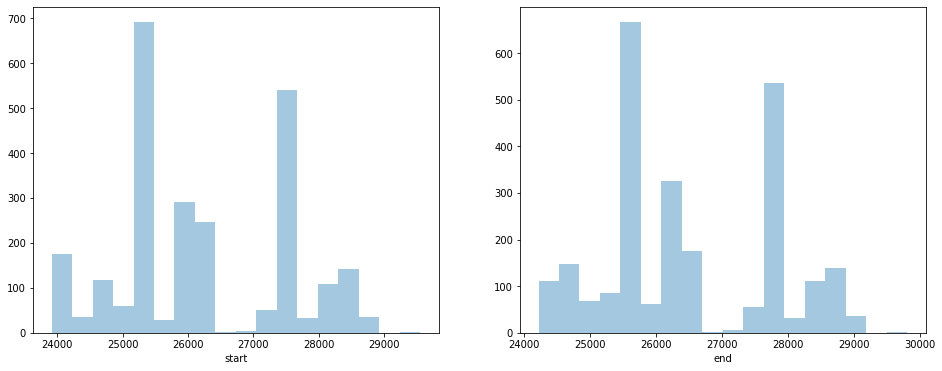

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_cds_orfs["E"]["start"], kde=False, ax=axs[0]);
sns.distplot(corona_cds_orfs["E"]["end"], kde=False, ax=axs[1]);

The distribution looks as expected. Now we should look at one of each product to make sure we are not including something else.

In [41]:
one_of_each_e_protein = corona_cds_orfs["E"].drop_duplicates("product")
display(HTML(one_of_each_e_protein.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AST13217.1,envelope protein,E,1,KX839246.1,CDS,07-SEP-2017,25386,25617,231,0.0
ANF29222.1,e protein,E,1,KX154689.1,CDS,30-APR-2017,27567,27816,249,0.0
BBM61481.1,small envelope protein,E,1,LC494182.1,CDS,08-FEB-2020,28385,28640,255,0.0
ABQ57210.1,small membrane protein,E,1,EF203064.1,CDS,09-OCT-2007,24531,24759,228,0.0
AIG54298.1,envelope (e) glycoprotein (3c),unknown,1,KF931628.1,CDS,25-MAR-2015,24199,24520,321,0.0
AGT21335.1,envelope small membrane protein,E,1,KF430219.1,CDS,26-SEP-2014,25307,25532,225,0.0
AID56669.1,envelope,unknown,1,KJ645635.1,CDS,17-JUN-2015,25404,25635,231,0.0
AHI85763.1,e,unknown,1,KF853202.1,CDS,16-FEB-2014,24215,24542,327,0.0
AAP94740.1,putative small envelope protein,unknown,1,AY345986.1,CDS,29-NOV-2003,26101,26332,231,0.0


Let's remove the references to the 3C frame, which is used to refer to a different transmembrane protein.

In [42]:
protein_3c = corona_cds_orfs["E"][(corona_cds_orfs["E"]["product"].str.contains("\(3c\)")) | 
                                  (corona_cds_orfs["E"]["gene"] == "3C")]
corona_cds_orfs["E"] = corona_cds_orfs["E"][(~corona_cds_orfs["E"].index.isin(protein_3c.index))]

Again as before let's make sure we are not leaving some "E" protein CDS on the remaining samples. This case it's much trickier to query, since the size and position it's similar to other ORFs in the genomes. Let's make a query not only by the length, but also by the gene position and analyze the product description for each one we find.

In [43]:
# start range
min_e_start = corona_cds_orfs["E"]["start"].min()
max_e_start = corona_cds_orfs["E"]["start"].max()

# end range
min_e_end = corona_cds_orfs["E"]["end"].min()
max_e_end = corona_cds_orfs["E"]["end"].max()

# length range
min_e_length = corona_cds_orfs["E"]["length"].min()
max_e_length = corona_cds_orfs["E"]["length"].max()

potential_e_cds = accessory_cds[((accessory_cds["length"] >= min_e_length)  & 
                                 (accessory_cds["length"] <= max_e_length)) & 
                                 ((accessory_cds["start"] >= min_e_start) & 
                                 (accessory_cds["start"] <= max_e_start)) &
                                 ((accessory_cds["end"] >= min_e_end) & 
                                 (accessory_cds["end"] <= max_e_end))]

print("[+] Unique products :", len(potential_e_cds["product"].unique()))
print("[+] Potential E proteins :", len(potential_e_cds))

[+] Unique products : 215
[+] Potential E proteins : 4759


We got quite a lot ORFs that can code for an E protein just by looking at the position and size. With only those parameters there is no way to tell if that's the case or not (that's exactly why we need something like machine learning to look at sequence patterns). In any case, if we already got the E protein for a given sample (oid) we could remove those from the potential CDS and explore the rest.

In [44]:
not_e_cds = potential_e_cds[potential_e_cds["oid"].isin(corona_cds_orfs["E"]["oid"])]
remaining_potential_e_cds = potential_e_cds[~potential_e_cds.index.isin(not_e_cds.index)]

# let's see if we can rule out some entries by looking at the product's description 
remaining_potential_e_cds = remaining_potential_e_cds[~remaining_potential_e_cds["product"].isin(not_e_cds["product"].unique())]

print("[+] Unique products :", len(remaining_potential_e_cds["product"].unique()))
print("[+] Remaining proteins :", len(remaining_potential_e_cds))

display(HTML(remaining_potential_e_cds.drop_duplicates("product").drop(hidden_cds_columns, axis=1).to_html()))

[+] Unique products : 18
[+] Remaining proteins : 199


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AIG54300.1,putative 4c protein,unknown,1,KF931628.1,CDS,25-MAR-2015,25373,25574,201,0.0
AVI69522.1,3c protein,3C,1,MG448607.1,CDS,06-MAR-2018,24258,24588,330,0.0
APY26855.1,orf3c,3C,1,KX236013.1,CDS,04-FEB-2017,24215,24542,327,0.0
AKV60432.1,3c,unknown,1,KP780179.1,CDS,16-AUG-2015,24124,24433,309,0.0
QDH43718.1,ns2,unknown,1,MN026164.1,CDS,07-JUL-2019,27857,28187,330,0.0
QDH43717.1,ns3,unknown,1,MN026164.1,CDS,07-JUL-2019,28173,28428,255,0.0
NP_040834.1,small virion-associated protein,3,1,NC_001451.1,CDS,13-AUG-2018,24206,24533,327,0.0
AVX27615.1,protein 3c,unknown,1,MG763935.1,CDS,15-APR-2018,24149,24479,330,0.0
AVX27618.1,protein 5b,unknown,1,MG763935.1,CDS,15-APR-2018,25681,25930,249,0.0


The rest looks pretty good, there aren't a lot of remaining proteins that could code for E. Even if one of these are, the pollution will be minimal.

In [45]:
duplicated = not(len(corona_cds_orfs["E"]["oid"].unique()) == len(corona_cds_orfs["E"]))
print("[+] Do we have duplicates?", duplicated)

# fishy samples, let's take these out
if(duplicated):
    dups = corona_cds_orfs["E"][corona_cds_orfs["E"][["oid"]].duplicated() == True]
    display(HTML(dups.drop(hidden_cds_columns, axis=1).to_html()))
    corona_cds_orfs["E"] = corona_cds_orfs["E"].drop_duplicates("oid", keep=False)

[+] Do we have duplicates? False


### 1.1.3 Membrane protein <a id="section6"></a>

Now it's time to analyze the "M" protein CDS. You know the drill.

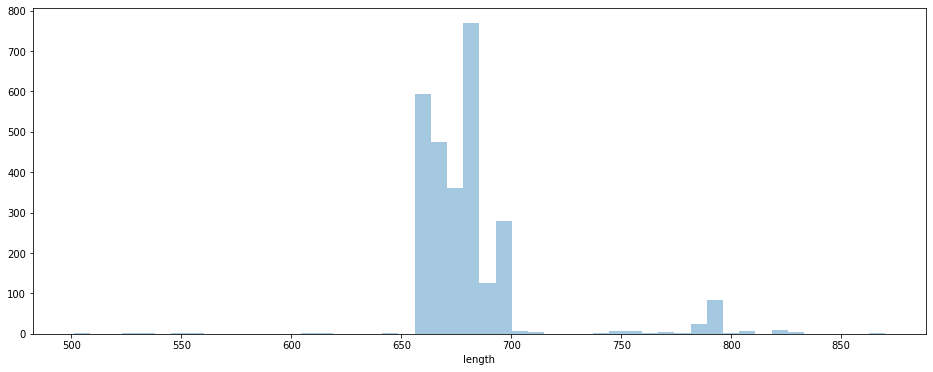

In [46]:
plt.figure(figsize=(16, 6))
corona_cds_orfs["M"] = corona_cds_orfs["M"][corona_cds_orfs["M"]["length"] > 300]
sns.distplot(corona_cds_orfs["M"]["length"], kde=False);

In [47]:
min_m_size = 600
max_m_size = 850

outliers_m_cds = corona_cds_orfs["M"][(corona_cds_orfs["M"]["length"] <= min_m_size) | 
                                      (corona_cds_orfs["M"]["length"] >= max_m_size)]

display(HTML(outliers_m_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ADV71730.1,membrane protein,unknown,1,GU393331.1,CDS,17-OCT-2011,24650,25175,525,0.0
AFG19730.1,membrane,unknown,1,JQ404409.1,CDS,01-APR-2012,26184,27054,870,0.0
AKA60058.1,membrane protein,M,1,KP202848.1,CDS,05-APR-2015,26034,26904,870,0.0
AXP11709.1,minor membrane protein 1,MM1,1,MF685025.1,CDS,26-AUG-2018,25965,26511,546,0.0
AYR18451.1,matrix protein,unknown,1,MH687942.1,CDS,12-NOV-2018,25789,26326,537,0.0
AYR18452.1,matrix protein,unknown,1,MH687942.1,CDS,12-NOV-2018,26397,26898,501,0.0
QDF43837.1,matrix protein,unknown,1,MK211378.1,CDS,30-JUN-2019,26356,26914,558,0.0


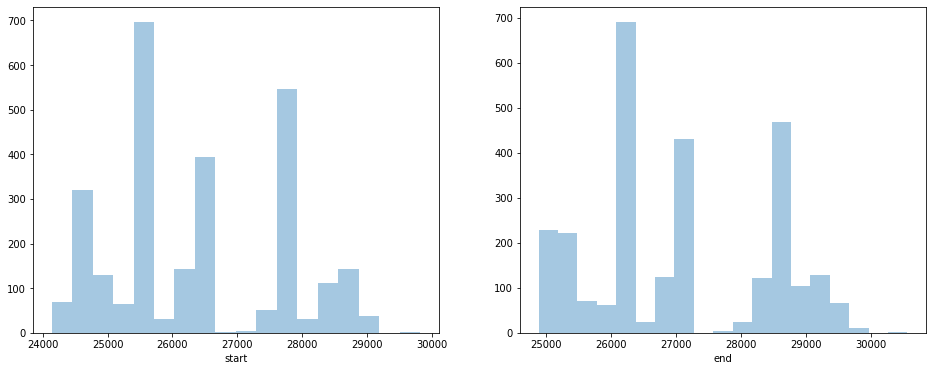

In [48]:
corona_cds_orfs["M"] = corona_cds_orfs["M"][corona_cds_orfs["M"]["length"] > min_m_size]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_cds_orfs["M"]["start"], kde=False, ax=axs[0]);
sns.distplot(corona_cds_orfs["M"]["end"], kde=False, ax=axs[1]);

In [49]:
one_of_each_m_protein = corona_cds_orfs["M"].drop_duplicates("product")
display(HTML(one_of_each_m_protein.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AAA70239.1,membrane protein,unknown,1,M95169.1,CDS,11-FEB-2002,24504,25182,678,0.0
AAF69337.1,integral membrane glycoprotein,ORF6,1,AF208066.1,CDS,11-MAY-2000,28741,29428,687,0.0
AAK29779.2,multispanning envelope protein,M,1,U00735.2,CDS,23-APR-2003,28694,29387,693,0.0
AAK83361.1,matrix protein,M,1,AF391541.1,CDS,05-FEB-2002,28690,29383,693,0.0
AAP13444.1,m protein,unknown,1,AY278741.1,CDS,25-JUL-2016,26397,27063,666,0.0
AAP13571.1,putative m protein,unknown,1,AY278554.2,CDS,31-JUL-2003,26382,27048,666,0.0
AAP30034.1,membrane protein m,unknown,1,AY278488.2,CDS,01-SEP-2009,26378,27044,666,0.0
AAP37021.1,putative membrane protein m,unknown,1,AY291451.1,CDS,25-FEB-2004,26397,27063,666,0.0
AAP41041.1,membrane glycoprotein m,unknown,1,AY274119.3,CDS,19-DEC-2017,26397,27063,666,0.0


In [50]:
not_m_proteins = corona_cds_orfs["M"][(corona_cds_orfs["M"]["gene"] == "E") |
                                      (corona_cds_orfs["M"]["product"].str.contains("orf3a")) |
                                      (corona_cds_orfs["M"]["product"].str.contains("putative membrane protein"))]
corona_cds_orfs["M"] = corona_cds_orfs["M"][(~corona_cds_orfs["M"].index.isin(not_m_proteins.index))]

Everything looks pretty good here, now let's see if we left some "M" CDS in the remaining entries

In [51]:
# start range
min_m_start = corona_cds_orfs["M"]["start"].min()
max_m_start = corona_cds_orfs["M"]["start"].max()

# end range
min_m_end = corona_cds_orfs["M"]["end"].min()
max_m_end = corona_cds_orfs["M"]["end"].max()

# length range
min_m_length = corona_cds_orfs["M"]["length"].min()
max_m_length = corona_cds_orfs["M"]["length"].max()

potential_m_cds = accessory_cds[((accessory_cds["length"] >= min_m_length)  & 
                                 (accessory_cds["length"] <= max_m_length)) & 
                                 ((accessory_cds["start"] >= min_m_start) & 
                                 (accessory_cds["start"] <= max_m_start)) &
                                 ((accessory_cds["end"] >= min_m_end) & 
                                 (accessory_cds["end"] <= max_m_end))]

print("[+] Unique products :", len(potential_m_cds["product"].unique()))
print("[+] Potential M proteins :", len(potential_m_cds))

[+] Unique products : 93
[+] Potential M proteins : 2565


Same than before, let's remove the samples we for which we already got the "M" protein

In [52]:
not_m_cds = potential_m_cds[potential_m_cds["oid"].isin(corona_cds_orfs["M"]["oid"])]
remaining_potential_m_cds = potential_m_cds[~potential_m_cds.index.isin(not_m_cds.index)]

# let's see if we can rule out some entries by looking at the product's description 
remaining_potential_m_cds = remaining_potential_m_cds[~remaining_potential_m_cds["product"].isin(not_m_cds["product"].unique())]

print("[+] Unique products :", len(remaining_potential_m_cds["product"].unique()))
print("[+] Remaining proteins :", len(remaining_potential_m_cds))

display(HTML(remaining_potential_m_cds.drop_duplicates("product").drop(hidden_cds_columns, axis=1).to_html()))

[+] Unique products : 2
[+] Remaining proteins : 2


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AUS29612.1,tm-glycoprotein,unknown,1,MG752895.1,CDS,27-JAN-2018,28398,29151,753,0.0
AAB86822.1,e1 glycoprotein,unknown,1,AF029248.1,CDS,25-JUL-2000,28967,29654,687,0.0


In [53]:
duplicated = not(len(corona_cds_orfs["M"]["oid"].unique()) == len(corona_cds_orfs["M"]))
print("[+] Do we have duplicates?", duplicated)

# fishy samples, let's take these out
if(duplicated):
    dups = corona_cds_orfs["M"][corona_cds_orfs["M"][["oid"]].duplicated() == True]
    dups = corona_cds_orfs["M"][corona_cds_orfs["M"]["oid"].isin(dups["oid"])]

    display(HTML(dups.drop(hidden_cds_columns, axis=1).to_html()))

[+] Do we have duplicates? True


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ALU34113.1,accessory membrane protein,MP,1,KU297956.1,CDS,04-MAY-2016,24784,25459,675,0.0
ALU34115.1,membrane protein,M,1,KU297956.1,CDS,04-MAY-2016,25677,26358,681,0.0
APG30999.1,accessory membrane protein,MP,1,KY019623.1,CDS,06-DEC-2016,24776,25451,675,0.0
APG31001.1,membrane protein,M,1,KY019623.1,CDS,06-DEC-2016,25669,26350,681,0.0
APG31006.1,accessory membrane protein,MP,1,KY019624.1,CDS,06-DEC-2016,24776,25451,675,0.0
APG31008.1,membrane protein,M,1,KY019624.1,CDS,06-DEC-2016,25669,26350,681,0.0
AXP11710.1,membrane protein,M,1,MF685025.1,CDS,26-AUG-2018,26515,27163,648,0.0
AXP11712.1,minor membrane protein 2,MM2,1,MF685025.1,CDS,26-AUG-2018,27638,28460,822,0.0
CDW77206.1,accessory membrane protein,MP,1,LM645057.1,CDS,16-DEC-2014,24784,25459,675,0.0


Quite a lot of duplicates, since we got spurious entries as "accessory membrane protein". We should remove those from the dataframe.

In [54]:
not_m_cds = dups[dups["gene"] != "M"]
corona_cds_orfs["M"] = corona_cds_orfs["M"][~corona_cds_orfs["M"].index.isin(dups.index)]

duplicated = not(len(corona_cds_orfs["M"]["oid"].unique()) == len(corona_cds_orfs["M"]))
print("[+] Do we have duplicates?", duplicated)

# fishy samples, let's take these out
if(duplicated):
    dups = corona_cds_orfs["M"][corona_cds_orfs["M"][["oid"]].duplicated() == True]
    dups = corona_cds_orfs["M"][corona_cds_orfs["M"]["oid"].isin(dups["oid"])]

    display(HTML(dups.drop(hidden_cds_columns, axis=1).to_html()))

[+] Do we have duplicates? False


### 1.1.4 Nucleoprotein <a id="section7"></a>

Finally, we'll look at the "N" coding segment which is the last structural protein we'll analyze.

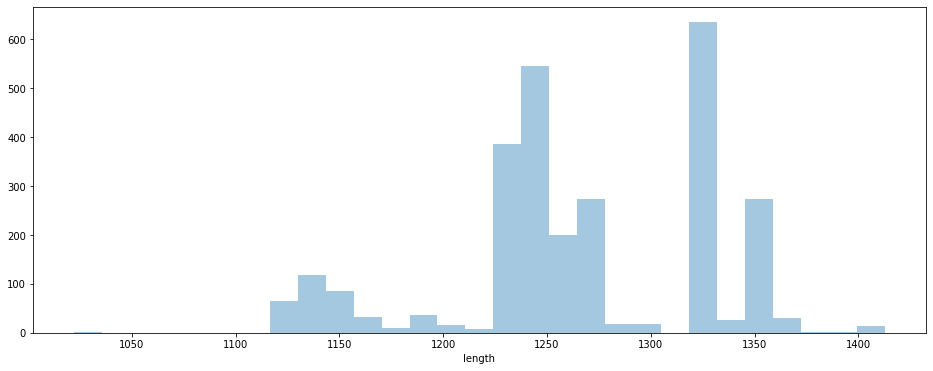

In [55]:
plt.figure(figsize=(16, 6))
corona_cds_orfs["N"] = corona_cds_orfs["N"][corona_cds_orfs["N"]["length"] > 1000]
sns.distplot(corona_cds_orfs["N"]["length"], kde=False);

In [56]:
min_m_size = 1100
max_m_size = 1500

outliers_n_cds = corona_cds_orfs["N"][(corona_cds_orfs["N"]["length"] <= min_m_size) | 
                                      (corona_cds_orfs["N"]["length"] >= max_m_size)]

display(HTML(outliers_n_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18509.1,nucleocapsid protein,unknown,1,MH687952.1,CDS,12-NOV-2018,26203,27225,1022,0.0


In [57]:
one_of_each_n_protein = corona_cds_orfs["N"].drop_duplicates("product")
display(HTML(one_of_each_n_protein.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AST13218.1,nucleocapsid protein,N,1,KX839246.1,CDS,07-SEP-2017,26328,27654,1326,0.0
ANF29224.1,n protein,N,1,KX154689.1,CDS,30-APR-2017,28543,29785,1242,0.0
ASV64363.1,nucleoprotein,N,1,KX900402.1,CDS,01-OCT-2018,26916,28065,1149,0.0
ABQ57212.1,nucleocapsid phosphoprotein,N,1,EF203064.1,CDS,09-OCT-2007,25468,26596,1128,0.0
AID56671.1,nucleocapsid,unknown,1,KJ645635.1,CDS,17-JUN-2015,26334,27660,1326,0.0
AHI85767.1,n,unknown,1,KF853202.1,CDS,16-FEB-2014,25939,27169,1230,0.0
APP92764.1,nucloecapsid protein,unknown,1,KU556807.1,CDS,21-DEC-2016,25941,27171,1230,0.0
AAP94744.1,putative nucleocapsid protein,unknown,1,AY345986.1,CDS,29-NOV-2003,28104,29373,1269,0.0
AAQ94070.1,nucleocapsid protein n,N,1,AY427439.1,CDS,21-OCT-2003,28103,29372,1269,0.0


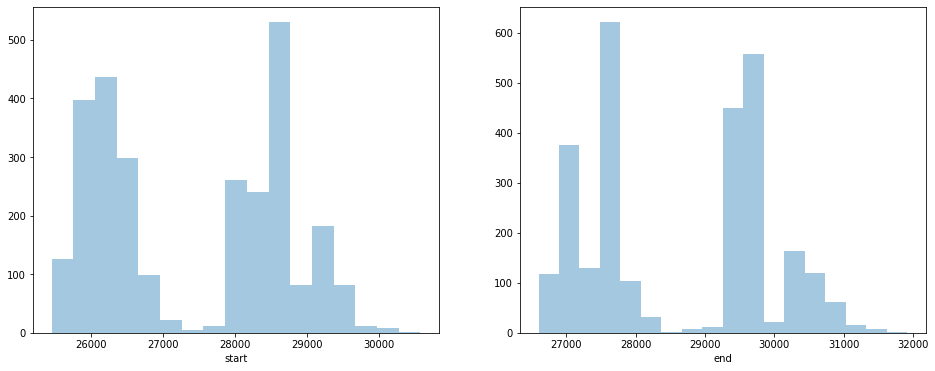

In [58]:
corona_cds_orfs["N"] = corona_cds_orfs["N"][~corona_cds_orfs["N"].index.isin(outliers_n_cds)]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_cds_orfs["N"]["start"], kde=False, ax=axs[0]);
sns.distplot(corona_cds_orfs["N"]["end"], kde=False, ax=axs[1]);

In [59]:
# start range
min_n_start = corona_cds_orfs["N"]["start"].min()
max_n_start = corona_cds_orfs["N"]["start"].max()

# end range
min_n_end = corona_cds_orfs["N"]["end"].min()
max_n_end = corona_cds_orfs["N"]["end"].max()

# length range
min_n_length = corona_cds_orfs["N"]["length"].min()
max_n_length = corona_cds_orfs["N"]["length"].max()

potential_n_cds = accessory_cds[((accessory_cds["length"] >= min_n_length)  & 
                                 (accessory_cds["length"] <= max_n_length)) & 
                                 ((accessory_cds["start"] >= min_n_start) & 
                                 (accessory_cds["start"] <= max_n_start)) &
                                 ((accessory_cds["end"] >= min_n_end) & 
                                 (accessory_cds["end"] <= max_n_end))]

print("[+] Unique products :", len(potential_n_cds["product"].unique()))
print("[+] Potential N proteins :", len(potential_n_cds))

[+] Unique products : 3
[+] Potential N proteins : 9


In [60]:
not_n_cds = potential_n_cds[potential_n_cds["oid"].isin(corona_cds_orfs["N"]["oid"])]
remaining_potential_n_cds = potential_n_cds[~potential_n_cds.index.isin(not_n_cds.index)]

# let's see if we can rule out some entries by looking at the product's description 
remaining_potential_n_cds = remaining_potential_n_cds[~remaining_potential_n_cds["product"].isin(not_n_cds["product"].unique())]

print("[+] Unique products :", len(remaining_potential_n_cds["product"].unique()))
print("[+] Remaining proteins :", len(remaining_potential_n_cds))

display(HTML(remaining_potential_n_cds.drop_duplicates("product").drop(hidden_cds_columns, axis=1).to_html()))

[+] Unique products : 3
[+] Remaining proteins : 9


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QBP84753.1,protein i,I,1,MK303624.1,CDS,30-MAR-2019,29057,30404,1347,0.0
AUS29615.1,tm-glycoprotein,unknown,1,MG752895.1,CDS,27-JAN-2018,30021,31245,1224,0.0
AVM87342.1,hypothetical protein,unknown,1,MG600028.1,CDS,08-NOV-2018,26077,27460,1383,0.0


We don't really know what "hypothetical protein" stands for, so we should remove that from our dataset.

In [61]:
hypothetical = accessory_cds[accessory_cds["product"] == "hypothetical protein"]
accessory_cds = accessory_cds[~accessory_cds.index.isin(hypothetical.index)]

Another pretty strange thing is that protein "I" is usually the "internal" protein within the N gene and it seems like it's length is almost equal. That doesn't makes much sense. In fact, let's plot the size distribution of the "I" protein.

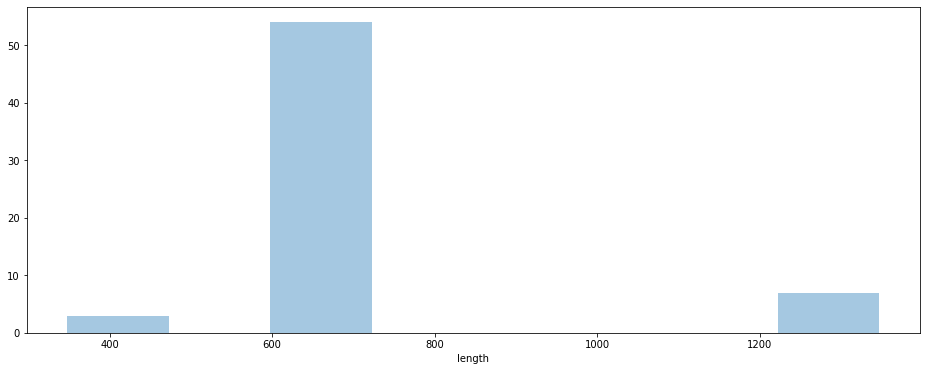

In [62]:
plt.figure(figsize=(16, 6))
protein_i = accessory_cds[accessory_cds["gene"] == "I"]
sns.distplot(protein_i["length"], kde=False);

So it seems like we have a few anomalies.

In [63]:
outliers_protein_i = protein_i[protein_i["length"] > 800]
display(HTML(outliers_protein_i.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QBP84753.1,protein i,I,1,MK303624.1,CDS,30-MAR-2019,29057,30404,1347,0.0
QBP84726.1,protein i,I,1,MK303621.1,CDS,30-MAR-2019,29057,30404,1347,0.0
QBQ01843.1,protein i,I,1,MK303625.1,CDS,30-MAR-2019,29064,30408,1344,0.0
QBP84708.1,protein i,I,1,MK303619.1,CDS,30-MAR-2019,29057,30404,1347,0.0
QBP84735.1,protein i,I,1,MK303622.1,CDS,30-MAR-2019,29058,30405,1347,0.0
QBP84744.1,protein i,I,1,MK303623.1,CDS,30-MAR-2019,29057,30404,1347,0.0
QBP84717.1,protein i,I,1,MK303620.1,CDS,30-MAR-2019,29058,30405,1347,0.0


What about the N protein in this samples? Let's take one as an example.

In [64]:
weird_case = corona_cds[corona_cds["oid"] == "MK303624.1"]
display(HTML(weird_case.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QBP84746.1,polyprotein,ORF1AB,1,MK303624.1,CDS,30-MAR-2019,189,21476,21288,0.0
QBP84747.1,ns2 protein,NS2A,1,MK303624.1,CDS,30-MAR-2019,21485,22322,837,0.0
QBP84748.1,hemagglutinin-esterase,HE,1,MK303624.1,CDS,30-MAR-2019,22333,23605,1272,0.0
QBP84749.1,spike glycoprotein,S,1,MK303624.1,CDS,30-MAR-2019,23619,27696,4077,0.0
QBP84750.1,ns5a protein,NS5A,1,MK303624.1,CDS,30-MAR-2019,27771,28101,330,0.0
QBP84751.1,envelope small membrane protein,E,1,MK303624.1,CDS,30-MAR-2019,28087,28345,258,0.0
QBP84752.1,membrane protein,M,1,MK303624.1,CDS,30-MAR-2019,28355,29048,693,0.0
QBP84753.1,protein i,I,1,MK303624.1,CDS,30-MAR-2019,29057,30404,1347,0.0
QBP84754.1,nucleocapsid protein,N,1,MK303624.1,CDS,30-MAR-2019,29118,29742,624,0.0


It looks like some sort of typo, where the CDS entry for the "N" protein should be the one of the "I" protein and vicersa. Weird. In any case, we already removed the N entry as an outlier for this case, and we should do the same for all of this I proteins.

In [65]:
accessory_cds = accessory_cds[~accessory_cds.index.isin(outliers_protein_i.index)]

### 1.1.5 Accessory proteins <a id="section8"></a>

Until now we collected CDS from ORF1 (both ORF1A and ORF1B) and the structural proteins S, E, M and N. We still need to take into account other accessory proteins which might vary depending on the virus strain.

In [66]:
print("[+] Accessory CDS :", len(accessory_cds))

[+] Accessory CDS : 9645


Now let's try to analyze the length distribution inside the remaining proteins to discover new groups of CDS. 

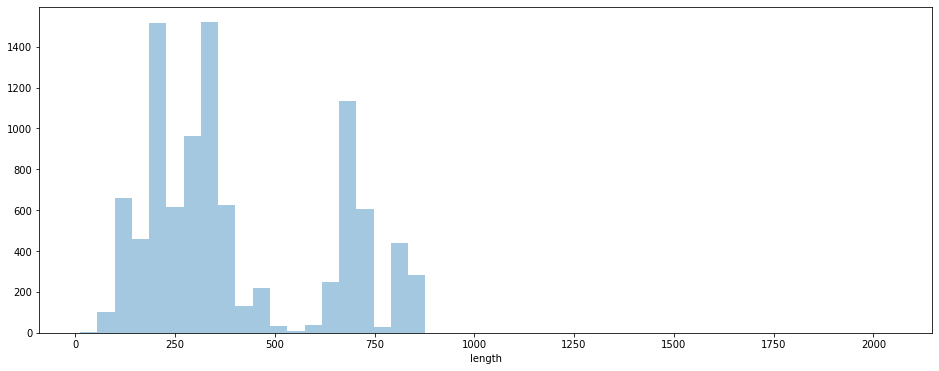

In [67]:
plt.figure(figsize=(16, 6))
sns.distplot(accessory_cds["length"], kde=False);

In [68]:
left_size = 900
right_size = 2500

group_cds = accessory_cds[(accessory_cds["length"] >= left_size) & (accessory_cds["length"] <= right_size)]

display(HTML(group_cds.drop_duplicates("product").drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ALK80245.1,ns4b-5 fusion protein,ORF4B-5,1,KT868870.1,CDS,09-MAR-2016,26072,27491,1419,0.0
AUS29615.1,tm-glycoprotein,unknown,1,MG752895.1,CDS,27-JAN-2018,30021,31245,1224,0.0
AVM87351.1,putative glycoprotein,unknown,1,MG600030.1,CDS,08-NOV-2018,28139,30185,2046,0.0


We don't really know what a "putative glycoprotein" might be, or if is referring to one that we already included in our dataset. Might be better if we remove any reference to it. In fact, we would like to remove pretty much all cases of CDS tagged as completely unknown.

In [69]:
hypothetical = accessory_cds[(accessory_cds["product"] == "putative glycoprotein") |
                            (accessory_cds["product"] == "unknown protein") | 
                            (accessory_cds["product"] == "unknown") | 
                            (accessory_cds["product"] == "putative protein")]
accessory_cds = accessory_cds[~accessory_cds.index.isin(hypothetical.index)]

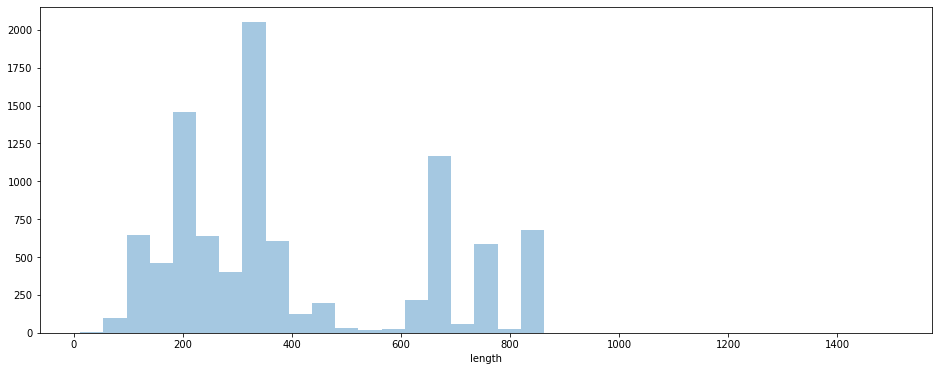

In [70]:
plt.figure(figsize=(16, 6))
sns.distplot(accessory_cds["length"], kde=False);

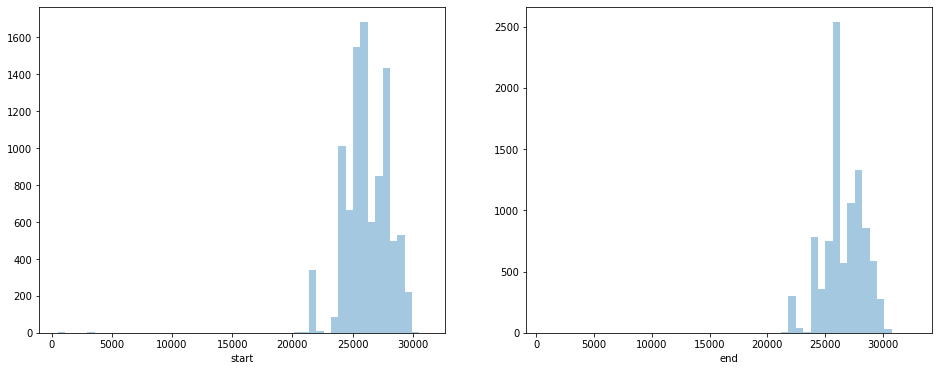

In [71]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(accessory_cds["start"], kde=False, ax=axs[0]);
sns.distplot(accessory_cds["end"], kde=False, ax=axs[1]);

In [72]:
left_size = 0
right_size = 20000

group_cds = accessory_cds[(accessory_cds["start"] >= left_size) & (accessory_cds["end"] <= right_size)]

if(len(group_cds) > 0):
    display(HTML(group_cds.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18659.1,nonstructural protein ns2a,unknown,1,MH687975.1,CDS,12-NOV-2018,18468,19299,831,0.0
AWV66918.1,u1 protein,U1,1,MG996765.1,CDS,24-JUN-2018,523,766,243,0.0
AWV66919.1,u2 protein,U2,1,MG996765.1,CDS,24-JUN-2018,775,1552,777,0.0
ABA02250.1,uncharacterized protein 1c,unknown,1,DQ182595.1,CDS,15-SEP-2005,717,1209,492,0.0
ABA02251.1,uncharacterized protein 1d,unknown,1,DQ182595.1,CDS,15-SEP-2005,2976,3279,303,0.0
ABA02252.1,uncharacterized protein 1e,unknown,1,DQ182595.1,CDS,15-SEP-2005,3549,3765,216,0.0
ABA02256.1,uncharacterized protein 1i,unknown,1,DQ182595.1,CDS,15-SEP-2005,12672,12855,183,0.0
ABA02258.1,uncharacterized protein 1k,unknown,1,DQ182595.1,CDS,15-SEP-2005,16496,16679,183,0.0


It seems that pretty much all the remaining CDS are somewhere between position \~20k until the 3' extreme of the genome, except for a few cases that we'll remove.

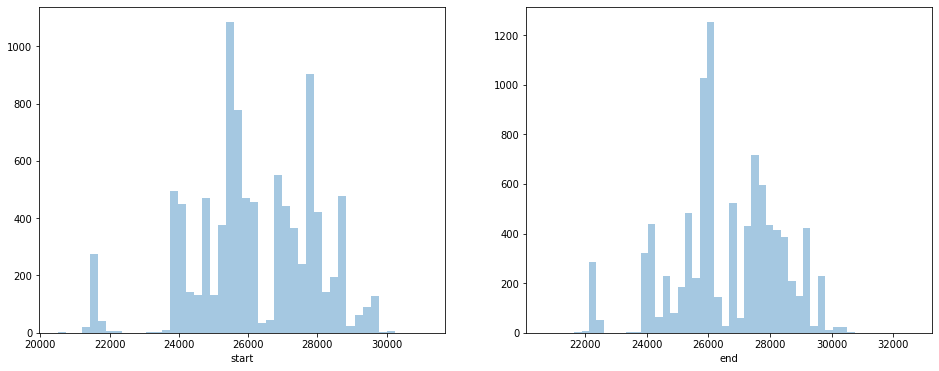

In [73]:
accessory_cds = accessory_cds[~accessory_cds.index.isin(group_cds.index)]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(accessory_cds["start"], kde=False, ax=axs[0]);
sns.distplot(accessory_cds["end"], kde=False, ax=axs[1]);

In [74]:
print("[+] Accessory CDS :", len(accessory_cds))

[+] Accessory CDS : 9485


At this point, all the CDS left are accessory uncharacterized and generic proteins, usually tagged as ORF*n*A/B/C, where *n* it's a number between 3 and 9. Without looking at the particular aminoacid sequence of each, it would be pretty hard to group them together into classes, since some families might have the same tag ORF*n* for different proteins (or not, but I'm not really sure at this point). We need a clustering algorithm to group this CDS together and we are going to deal with that later. 

For now, we'll use the remaining CDS as a generic "UNDEF" class for our supervised training algorithm.

One last thing we should do is to take care the nested ORFs in the accessory proteins dataframe. Some of them might be included in other the CDS in the training set and might be a source of pollution. Even thought the domain HMM scan could take care of that (by including alignment positional information), at this stage we are not looking to consider those corner cases in the classification stage.

In [75]:
nested_frames = []
for accessory_protein, accessory_row in accessory_cds.iterrows():
    
    for cls in corona_cds_orfs:
        if cls is not "UNDEF":
            matches = corona_cds_orfs[cls][corona_cds_orfs[cls]["oid"] == accessory_row["oid"]]

            if len(matches) > 0:
                start = matches["start"].values[0]
                end = matches["end"].values[0]
                                    
                if accessory_row["start"] >= start and accessory_row["end"] <= end:
                    nested_frames.append(accessory_protein)
        
    
print("[+] found", len(nested_frames), "nested frames")

[+] found 937 nested frames


In addition to remove the nested ORFs, we perform a last and very important step which is to only use samples where we collected the 4 structural proteins S,E, M and N. We do this to avoid including any of this proteins as part of the "UNDEF" class in our training set by mistake.

In [76]:
print("[+] got accessory :", len(accessory_cds))

# put ORF1A nad ORF1B into this dataframe
corona_cds_orfs["ORF1A"] = orf1a_cds
corona_cds_orfs["ORF1B"] = orf1b_cds

corona_cds_orfs["UNDEF"] = accessory_cds[~accessory_cds.index.isin(nested_frames)]

# common set of genomes we know for sure we have the 4 structural proteins
lst = set(corona_cds_orfs["S"]["oid"]) & set(corona_cds_orfs["E"]["oid"]) & set(corona_cds_orfs["M"]["oid"]) & set(corona_cds_orfs["N"]["oid"])

# let's keep only the samples with genes we are sure are not the ones above
corona_cds_orfs["UNDEF"] = corona_cds_orfs["UNDEF"][corona_cds_orfs["UNDEF"]["oid"].isin(lst)]

for cds in corona_cds_orfs:
    print("[+] total", cds, "CDS :", len(corona_cds_orfs[cds]))
    
with open(cache_cds_orfs_file, "wb") as handle:
    pickle.dump(corona_cds_orfs, handle, protocol=pickle.HIGHEST_PROTOCOL)
                                                 
print("[+] wrote", cache_cds_orfs_file)

[+] got accessory : 9485
[+] total S CDS : 2734
[+] total E CDS : 2495
[+] total M CDS : 2754
[+] total N CDS : 2795
[+] total HE CDS : 381
[+] total ORF1A CDS : 1296
[+] total ORF1B CDS : 192
[+] total UNDEF CDS : 6732
[+] wrote .cache_cds_orfs.pkl


So far, we know that the length and the start position are enough to identify a group of proteins in the genome (the really big ones, such as ORF1A/B and maybe even S and N). But in general, this is not true. We need a generic algorithm that also takes into account patterns and similarities in the translated aminoacid sequence of each frame.

Proteins are generally composed of one or more functional regions, commonly termed domains. Different combinations of domains give rise to the diverse range of proteins and the identification of each within proteins can provide insights into their function and find similarities among them.

This is where a database, such as [Pfam](https://pfam.xfam.org/), comes to play. Within the Pfam collection, each domain family is defined by a manually selected and aligned set of protein sequences, which is used to construct a profile HMM of the domain. We'll use Pfam protein domains as features for identifying and classify each CDS into the corresponding protein.

## 1.2 ORF tagging <a id="section9"></a>

### 1.2.1 ORF1 random forest classifier <a id="section11"></a>

The classification case for ORF1 is different than the rest of the proteins, since is the biggest coding frame (~13kbp) in the genome and appears pretty much at the beginning (by definition, that's it ORF1). We don't really need to look at the translated sequence for this case, but rather at other properties related to its position and structure. For example, does the biggest gene of the genome contains a slippery sequence ([UUUAAAC](https://en.wikipedia.org/wiki/Slippery_sequence)) near the extreme of its 3' end? And if it does, how much is the translated sequence extending if we do a -1 frameshift? If that new gene (ORF1AB) it's around ~21kbp is consistent to what we know, otherwise we are dealing with an outlier.

Therefore,if a genome doesn't have an ORF1 gene with those characteristics, we might want to take it out from our DB since it's different to the one we are ultimately interested about (SARS-CoV-2) or it might have some sort of mistake in the sequence.

To classify ORF1A  we don't need anything fancy, a [random forest](https://en.wikipedia.org/wiki/Random_forest) should do the job and deal efficiently with the amount and type of features we are dealing here. For [other proteins](#section12), we are going to use neural networks, which is a more scalable algorithm for both number of features and number of samples. 

Let's start by building out training set. For a given ORF, we should get it's size and and starting codon position. Additionally, we should get the slippery sequence near the 3' end (if any) and perform the translation to get the final size of ORF1AB.

We already got a list of ORF1AB genes tagged in CDS in our database that we can use as a reference to craft the dataset.

[+] min ORF1AB fraction (of the genome) : 0.6455979099121786
[+] max ORF1AB fraction : 0.792448656023008
[+] average ORF1AB fraction : 0.7236137014573185
[+] std ORF1AB fraction : 0.016355387923314292


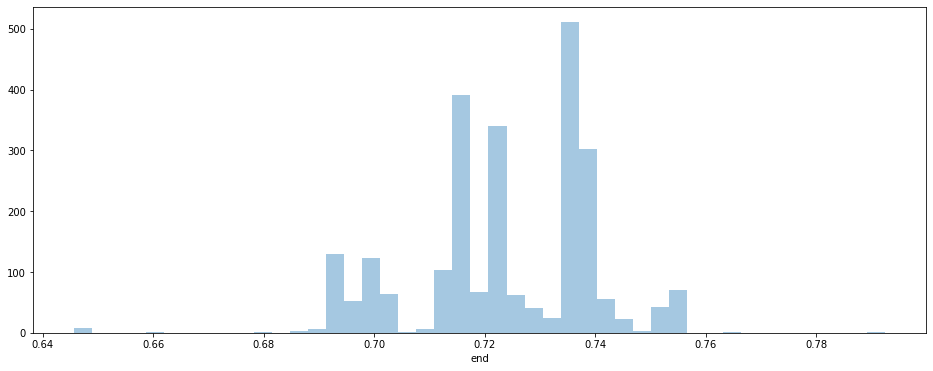

In [77]:
columns = ["start", "end"]

orf1ab_frame = {i: dict() for i in columns}

for protein_id, row in orf1ab.iterrows():
    sample = corona[corona.index == row["oid"]]
    genome = sample["sequence"].values[0]

    # start / end codon of the gene
    start = row["start"]
    end = row["end"]

    orf1ab_frame["start"][protein_id] = float(start) / float(len(genome))
    orf1ab_frame["end"][protein_id] = float(end) / float(len(genome))

tdf_orf1ab = pd.DataFrame(orf1ab_frame)
tdf_orf1ab.index.name = "id"

min_orf1ab_end = tdf_orf1ab["end"].min()
max_orf1ab_end = tdf_orf1ab["end"].max()
mean_orf1ab_end = tdf_orf1ab["end"].mean()
sigma_orf1ab_end = tdf_orf1ab["end"].std()

plt.figure(figsize=(16, 6))
sns.distplot(tdf_orf1ab["end"], kde=False);

print("[+] min ORF1AB fraction (of the genome) :", min_orf1ab_end)
print("[+] max ORF1AB fraction :", max_orf1ab_end)
print("[+] average ORF1AB fraction :", mean_orf1ab_end)
print("[+] std ORF1AB fraction :", sigma_orf1ab_end)

As we can see, pretty much 60% to 80% of the genome goes until the end of the ORF1AB gene. If translation of ORF1A results in an extended gene that ends up much further from this average value, we should consider it an anomaly (i.e. we don't want our algorithm to tag it automatically)

In [78]:
SLIPPERY_THRESHOLD = 0.9

def get_training_set(cds_classes):
    columns = ["start", "end", "frameshifted", "length", "slippery", "type"]
    slippery_sequence = "TTTAAAC"

    dataset_frame = {i: dict() for i in columns}

    for cls in cds_classes:
        # get CDS group
        df = corona_cds_orfs[cls]

        for index, row in df.iterrows():
            sample = corona[corona.index == row["oid"]]
            genome = sample["sequence"].values[0]

            # start / end codon of the gene
            start = row["start"]
            end = row["end"]

            gene = genome[start:end]

            # slippery sequence relative position
            slippery_when_wet = gene.rfind(slippery_sequence)
            if slippery_when_wet == -1:
                # if it doesn't have a slippery sequence, it's not something we want to tag as ORF1A
                dataset_frame["slippery"][index] = 0.0
                dataset_frame["type"][index] = "UNDEF"
                dataset_frame["frameshifted"][index] = float(end) / float(len(genome))
            else:
                slippery_position = float(slippery_when_wet) / float(row["length"])
                dataset_frame["slippery"][index] = slippery_position

                til_end_gene = genome[:end]
                slippery_when_wet = til_end_gene.rfind(slippery_sequence)

                slippery_when_wet += len(slippery_sequence)
                shifted_gene = genome[start:slippery_when_wet] + genome[slippery_when_wet - 1:len(genome)]

                last_nt_shift = len(shifted_gene)%3
                if len(shifted_gene)%3 == 0:
                    shifted_gene = shifted_gene[:len(shifted_gene)]
                else:
                    shifted_gene = shifted_gene[:-last_nt_shift]
                
                rfs_length = 3.0 * len(shifted_gene.translate(to_stop=True))

                extended_length = float(rfs_length + start) / float(len(genome))
                dataset_frame["frameshifted"][index] = extended_length

                if (slippery_position > SLIPPERY_THRESHOLD) and \
                        (min_orf1ab_end < extended_length < max_orf1ab_end):
                    dataset_frame["type"][index] = cls
                else:
                    dataset_frame["type"][index] = "UNDEF"

            dataset_frame["length"][index] = row["length"]
            dataset_frame["start"][index] = float(start) / float(len(genome))
            dataset_frame["end"][index] = float(end) / float(len(genome))

    training_df = pd.DataFrame(dataset_frame)
    training_df.index.name = "id"

    return training_df

cds_classes = ["ORF1A", "UNDEF"]
training_orf1_df = get_training_set(cds_classes)

print("[+] got", len(training_orf1_df), "training points")

[+] got 8028 training points


The details of the training procedure, including k-fold cross validation with 80%-20% split for the train-test respectively it's [here](./training/cds_orf1_rf.py). The logs of the latest run it's [here](./models/cds_orf1_rf.txt), along with the confusion matrices for each case.

As expected, the problem it's pretty well defined, and there is a clear separation of the ORF1A gene from the rest using the features we choose, giving a perfect classification score for each run. On this notebook, we'll train using our entire data set and present our metrics based on that, since we did cross-validation and parameter tunning elsewhere. 

In [79]:
def print_missed(training_df, model):
    df = training_df.copy()

    cls = df["type"].unique()
    class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}
    categories_map = {v: k for k, v in class_map.items()}

    x = df.values[:, :-1]
    y_pred = model.predict(x)

    y_pred = np.vectorize(categories_map.get)(y_pred)
    df["predicted"] = y_pred

    misses = df[df["type"].values != df["predicted"].values]

    missed_cds = corona_cds[corona_cds.index.isin(misses.index)][
        ["product", "start", "end", "length", "gene", "oid"]]
    missed_cds["type"] = misses["type"]
    missed_cds["predicted"] = misses["predicted"]

    display(HTML(missed_cds.to_html()))
    
# get classes
cls = training_orf1_df["type"].unique()
orf1a_class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}
    
t_data = training_orf1_df.values

# training set
x_train = t_data[:, :-1]
y_train = np.vectorize(orf1a_class_map.get)(t_data[:, -1])

orf1a_rf = RandomForestClassifier()
orf1a_rf.fit(x_train, y_train)

y_pred = orf1a_rf.predict(x_train)

target_names = cls
hits = (y_train == y_pred)

feature_names = training_orf1_df.columns[:-1].values
importances = pd.DataFrame(np.transpose(orf1a_rf.feature_importances_), 
                           columns=["importances"])
importances.index = feature_names
display(HTML(importances.to_html()))

accuracy = float(np.count_nonzero(hits)) / float(len(hits))

matrix = confusion_matrix(y_train, y_pred)

mdf = pd.DataFrame(matrix, columns=cls)
mdf.index = cls
display(HTML(mdf.to_html()))

report = classification_report(y_train, y_pred, target_names=target_names, output_dict=True)
repdf = pd.DataFrame(report).transpose()
display(HTML(repdf.to_html()))

# serialize classifier
joblib.dump(orf1a_rf, orf1_rf_classifier, compress=9)
print("[+] saved model to disk")

if(accuracy < 1.0):
    print_missed(tdf, corona_cds, orf1a_rf)

,importances
start,0.139538
end,0.239240
frameshifted,0.002674
length,0.259317
slippery,0.359231


,ORF1A,UNDEF
ORF1A,1289,0
UNDEF,0,6739


,precision,recall,f1-score,support
ORF1A,1.0,1.0,1.0,1289.0
UNDEF,1.0,1.0,1.0,6739.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,8028.0
weighted avg,1.0,1.0,1.0,8028.0


[+] saved model to disk


### 1.2.2 ORF1A/ORF1AB tagging <a id="section12"></a>

Now we can use this model to tag ORF1A genes and construct ORF1AB from them to assign labels in our dataset.

In [80]:
def get_prediction_set(predict_orfs):
    columns = ["start", "end", "frameshifted", "length", "slippery"]
    slippery_sequence = "TTTAAAC"

    dataset_frame = {i: dict() for i in columns}
        
    for index, row in predict_orfs.iterrows():   
        sample = corona[corona.index == row["id"]]
        genome = sample["sequence"].values[0]
        
        # start / end codon of the gene
        start = row["start"]
        end = row["end"]

        gene = genome[start:end]

        # slippery sequence relative position
        slippery_when_wet = gene.rfind(slippery_sequence)
        if slippery_when_wet == -1:
            # if it doesn't have a slippery sequence, it's not something we want to tag as ORF1A
            dataset_frame["slippery"][index] = 0.0
            dataset_frame["frameshifted"][index] = float(end) / float(len(genome))
        else:
            slippery_position = float(slippery_when_wet) / float(row["length"])
            dataset_frame["slippery"][index] = slippery_position

            til_end_gene = genome[:end]
            slippery_when_wet = til_end_gene.rfind(slippery_sequence)

            slippery_when_wet += len(slippery_sequence)
            shifted_gene = genome[start:slippery_when_wet] + genome[slippery_when_wet - 1:len(genome)]
            
            last_nt_shift = len(shifted_gene)%3
            if len(shifted_gene)%3 == 0:
                shifted_gene = shifted_gene[:len(shifted_gene)]
            else:
                shifted_gene = shifted_gene[:-last_nt_shift]
            
            rfs_length = 3.0 * len(shifted_gene.translate(to_stop=True))

            extended_length = float(rfs_length + start) / float(len(genome))
            dataset_frame["frameshifted"][index] = extended_length

        dataset_frame["length"][index] = row["length"]
        dataset_frame["start"][index] = float(start) / float(len(genome))
        dataset_frame["end"][index] = float(end) / float(len(genome))

    predicted_df = pd.DataFrame(dataset_frame)
    predicted_df.index.name = "id"

    return predicted_df

undef_orfs = corona_db[(corona_db["type"] == "ORF") & (corona_db["label"] == "UNDEF")]
undef_orfs_df = get_prediction_set(undef_orfs)
print("[+] got", len(undef_orfs_df), "orfs")

[+] got 45336 orfs


In [81]:
predicted_classes = orf1a_rf.predict(undef_orfs_df.values)

orf1a_categories_map = {v: k for k, v in orf1a_class_map.items()}
orf1a_predicted = np.vectorize(orf1a_categories_map.get)(predicted_classes) 

orf1a_rf_tagged_orfs = undef_orfs_df.copy()
orf1a_rf_tagged_orfs["label"] = orf1a_predicted

orf1a_tagged = orf1a_rf_tagged_orfs[orf1a_rf_tagged_orfs["label"] == "ORF1A"]
not_orf1a_tagged = orf1a_rf_tagged_orfs[orf1a_rf_tagged_orfs["label"] != "ORF1A"]

print("[+] tagged", len(orf1a_tagged), "ORF1A genes")

[+] tagged 3799 ORF1A genes


Let's look at the length distribution of ORF1A tagged genes set and the remaining ones to assess the performance of the RF classifier.

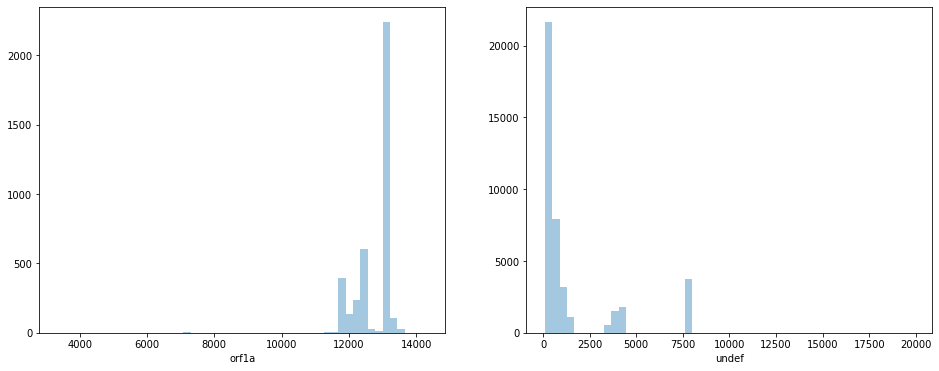

In [82]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_tagged["length"], kde=False, ax=axs[0], axlabel="orf1a");
sns.distplot(not_orf1a_tagged["length"], kde=False, ax=axs[1], axlabel="undef");

The distribution looks pretty good, let's see how many genomes our algorithm didn't tag an ORF1A gene.

In [83]:
corona_tagged_db = corona_db.copy()
corona_tagged_db.loc[orf1a_rf_tagged_orfs.index, "label"] = orf1a_rf_tagged_orfs["label"].values
tagged = corona_tagged_db[corona_tagged_db["label"] == "ORF1A"]
not_tagged = corona_tagged_db[~corona_tagged_db["id"].isin(tagged["id"])]
not_tagged_ids = not_tagged["id"].unique()
print("[+] got", len(not_tagged_ids), " not tagged samples")

[+] got 32  not tagged samples


So what's going on with this samples that makes the first gene different from the ones in our training set?

In [84]:
missing_orf1a = corona_db[corona_db["id"].isin(not_tagged_ids)]
not_tagged_orf1a = missing_orf1a.sort_values("length", ascending=False).drop_duplicates(["id"],keep="first")
tdf_not_tagged_orf1a = not_orf1a_tagged[not_orf1a_tagged.index.isin(not_tagged_orf1a.index)]
display(HTML(tdf_not_tagged_orf1a.to_html()))

,start,end,frameshifted,length,slippery,label
id,,,,,,
MG546689.1|ORF@00292,0.010416,0.424969,0.102443,11622,0.219928,UNDEF
KY620116.1|ORF@00525,0.018963,0.447318,0.514936,11859,0.996880,UNDEF
AY297028.1|ORF@00523,0.017601,0.288777,0.286152,8058,0.988459,UNDEF
AY559081.1|ORF@00251,0.008447,0.450936,0.470521,13149,0.998327,UNDEF
HM776941.1|ORF@12528,0.438348,0.712526,0.501645,7836,0.228178,UNDEF
KP780179.1|ORF@00433,0.015801,0.741744,0.447907,19893,0.594330,UNDEF
KX512809.1|ORF@00234,0.008312,0.421797,0.433200,11640,0.996821,UNDEF
MG546688.1|ORF@00292,0.010414,0.424923,0.102432,11622,0.219928,UNDEF
KY928065.1|ORF@00292,0.010405,0.449453,0.102341,12321,0.207451,UNDEF


We can divide this anomalies in 2 classes to analyze each case better. The anomalies seems to occur on the "slippery" features, which is the relative position within the gene where the slippery sequence is. In our training samples, we observed that's usually at the end, but here we have some samples where the sequence is in the middle (or even below). That's strange, and doesn't makes much sense, since the translation of ORF1AB must occur at the end of ORF1A.

Let's look at the "EPI_ISL_415158" which seems to be a variant of the SARS-CoV-2 virus.

In [85]:
display_info("EPI_ISL_415158")
strange_sample_genome = corona[corona.index == "EPI_ISL_415158"]["sequence"].values[0]

,length,date,information,description,unknown,country,host,strain,collection_date
id,,,,,,,,,
EPI_ISL_415158,29843,2020-03-01,1.191611,hCoV-19/Belgium/QKJ-03015/2020|EPI_ISL_415158|2020-03-01,0.0,belgium,homo sapiens,hCoV-19,2020


,type,label,date,collection,start,end,length,unknown
rid,,,,,,,,
EPI_ISL_415158|UTR@00000,UTR,5UTR,2020-03-01,2020,0,240,240,0.0
EPI_ISL_415158|ORF@00240,ORF,UNDEF,2020-03-01,2020,240,13377,13137,0.0
EPI_ISL_415158|ORF@13285,ORF,UNDEF,2020-03-01,2020,13285,13441,156,0.0
EPI_ISL_415158|ING@13441,ING,UNDEF,2020-03-01,2020,13441,13742,301,0.0
EPI_ISL_415158|ORF@13742,ORF,UNDEF,2020-03-01,2020,13742,21530,7788,0.0
EPI_ISL_415158|ORF@21510,ORF,UNDEF,2020-03-01,2020,21510,25359,3849,0.0
EPI_ISL_415158|ORF@25306,ORF,UNDEF,2020-03-01,2020,25306,25423,117,0.0
EPI_ISL_415158|ORF@25367,ORF,UNDEF,2020-03-01,2020,25367,26195,828,0.0
EPI_ISL_415158|ORF@26157,ORF,UNDEF,2020-03-01,2020,26157,26256,99,0.0


It seems like there is an additional ORF of 156 nucleotides long between the ORF1A and ORF1B gene. That's pretty strange, compared to others strains of the virus. So where are all the slippery sequences here?

In [86]:
slip = 0
while slip != -1:
    slip = strange_sample_genome.find("TTTAAAC", start=slip+1)
    if slip != -1:
        print("[+] found slippery sequence at :", slip)

[+] found slippery sequence at : 1638
[+] found slippery sequence at : 6059
[+] found slippery sequence at : 6719
[+] found slippery sequence at : 13436
[+] found slippery sequence at : 16643
[+] found slippery sequence at : 18449
[+] found slippery sequence at : 20201
[+] found slippery sequence at : 20791
[+] found slippery sequence at : 24410


Quite strange, the slippery sequence it's partially included into this new spurious ORF at the end, where the "stop codon" (TAA) it's actually part of the slippery sequence itself. How does translation works for this case? ORF1A will be translated until the end codon (13137) but is never going to get to the slippery sequence at 13436.

Let's take out this samples for now, until we know how to deal with them. It's pretty good that the algorithm doesn't classify this cases as ORF1A automatically, since is very valuable to get insights if anomalies such as this one.

In [87]:
corona_tagged_db = corona_tagged_db[~corona_tagged_db["id"].isin(not_tagged_ids)]
print("[+] got", len(corona_tagged_db["id"].unique()), "samples")
print("[+] got", len(corona_tagged_db[corona_tagged_db["label"] == "ORF1A"]), "ORF1A tags")

with open(cache_corona_tagged_db, "wb") as handle:
    pickle.dump(corona_tagged_db, handle, protocol=pickle.HIGHEST_PROTOCOL)
                                                 
print("[+] wrote", cache_corona_tagged_db)

[+] got 3799 samples
[+] got 3799 ORF1A tags
[+] wrote .cache_corona_tagged_db.pkl


### 1.2.3 Structural protein domain extraction <a id="section13"></a>

We are going to use the following attributes to classify structural proteins using the CDS as a training set :

* Size of the gene
* For each one of the 79 domains, one feature for the hit score and others for the position (from and to) of the domain within the protein (alignment coordinates). 

The Pfam database contains more than \~17k domains. We are only interested in the set of domains in the coronavirus CDS we have. We'll craft a fasta file with every coding region in our dataset and run a scan against the latest [PFAM database](ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam33.0/Pfam-A.hmm.gz) to collect the relevant domains for classification.

First, we should make a FASTA file with all the undefined (i.e. untagged) sequences we have in our database to construct a complete list of domain matches.

In [88]:
CDS_FASTA_FILE = "./data/pfam/corona_cds.fasta"

undef_orfs = corona_tagged_db[(corona_tagged_db["type"] == "ORF") & (corona_tagged_db["type"] == "UNDEF")]
    
records = []
for index, row in undef_orfs.iterrows():
    record = SeqRecord(Seq(row["protein"]), id=index, description=row["id"])
    records.append(record)

SeqIO.write(records, CDS_FASTA_FILE, "fasta")

print("[+] fasta file written :", CDS_FASTA_FILE)

[+] fasta file written : ./data/pfam/corona_cds.fasta


After running a scan using that fasta file and the full Pfam database, we obtained a list of 79 unique protein domains that belongs to the cornavirus family CDS.

*$ hmmscan --domtblout matches_cds.scan --cut_ga --cpu 8 ./pfamdbs/FULL/Pfam-A.hmm corona_cds.faa*

The scans results are [here](./data/pfam/matches_cds.scan). After extracting those Pfam entries from the full database and combining them with the [SARS-CoV-2 special update](https://xfam.wordpress.com/2020/04/02/pfam-sars-cov-2-special-update/) the Pfam team did, we created a [CoV Pfam database](./data/pfam/Pfam-A.CoV.hmm) of protein domains (to also reflect the new domain naming convention).

We'll use this database to identify the domains on each CDS as features for our training dataset. Here is the list of the top 15 domains with more hits from the database.

In [89]:
SCAN_FILE = "./data/pfam/matches_cds.scan"

def get_domain_matches(scan_file):
    columns = ["id", "domain", "accession", "score", "from", "to"]
    domains_frame = {i: list() for i in columns}

    with open(scan_file) as matches_file:
        for line in matches_file:
            row = line[:-1]
            if row != "#":
                toks = row.split()

                # domain
                domain = toks[0]

                # accession number
                acc = toks[1].split(".")[0]

                if "PF" in acc:
                    domains_frame["accession"].append(acc)
                    domains_frame["domain"].append(domain)

                    # protein id
                    domains_frame["id"].append(toks[3])

                    # score
                    domains_frame["score"].append(float(toks[7]))

                    # from
                    domains_frame["from"].append(int(toks[17]))
                    domains_frame["to"].append(int(toks[18]))

    domain_matches = pd.DataFrame.from_dict(domains_frame)

    return domain_matches

PFAM_DATABASE = "./data/pfam/Pfam-A.CoV.hmm"
command = ["hmmscan", "--domtblout", SCAN_FILE, "-E 1e-2", "--cpu", "64", PFAM_DATABASE, CDS_FASTA_FILE]

with open(os.devnull, "w") as f:
    subprocess.call(command, stdout=f)

print("[+] finish running hmmscan")

pfam_matches = get_domain_matches(SCAN_FILE)

freqs = pfam_matches["domain"].value_counts()
display(HTML(freqs.reset_index().head(15).to_html()))

[+] finish running hmmscan


,index,domain
0,CoV_S1_C,4899
1,CoV_S2,4554
2,CoV_NSP2_C,4277
3,CoV_nucleocap,4116
4,CoV_NSP6,3205
5,DUF2959,2808
6,CoV_M,2778
7,CoV_NSP4_N,2521
8,CoV_E,2414
9,bCoV_S1_N,2345


This is how the Pfam matches dataframe looks like; for each protein ID we collected a domain match along with the score and position within the CDS. Since the same domain might appear in several proteins we should include information about its position. Also some domains might appear more than once within a coding segment, so we'll have to take that into account.

In [90]:
display(HTML(pfam_matches.head(7).to_html()))

,id,domain,accession,score,from,to
0,AST13215.1,CoV_S2,PF01601,736.5,379,427
1,AST13215.1,CoV_S2,PF01601,736.5,781,1345
2,AST13215.1,Corona_S1,PF01600,374.4,235,737
3,AST13215.1,CoV_S1_C,PF19209,86.2,648,704
4,AST13215.1,CoV_S1_C,PF19209,86.2,716,743
5,AST13215.1,DUF2959,PF11172,11.3,1016,1078
6,AST13215.1,DUF2959,PF11172,11.3,1275,1324


Let's see how many domains appear more than once within the same protein, and what is the maximum number of times they could appear in the whole dataset.

In [91]:
duplicated = pfam_matches[pfam_matches.duplicated(["id", "accession"], keep=False)]
duplicated_domains = duplicated.groupby(["id", "domain"]).size().sort_values(ascending=False)
duplicated_domains.reset_index(name = "count")

,id,domain,count
0,AVI69485.1,CoV_S1_C,6
1,ADI80511.1,CoV_NSP2_C,6
2,YP_009019181.1,CoV_NSP2_C,6
3,AXN92248.1,CoV_NSP2_C,6
4,AVM80703.1,CoV_NSP2_C,5
...,...,...,...
15785,ASU90240.1,CoV_NSP2_N,2
15786,ASU90229.1,CoV_NSP7,2
15787,ASU90229.1,CoV_NSP6,2
15788,ASU90229.1,CoV_NSP4_N,2


We can see that some domains appear 6 times within a single protein sequence, which is a consequence if using a low E-value for cutoff. We have to take this into account when building our training set, since we'll have a feature for each time a given domain might appear (or not) in a protein. The following function takes care of that.

In [92]:
def get_training_set(cds_classes, domain_matches):
    columns = ["length"]

    domain_count = domain_matches.groupby(["domain", "id"]).size().reset_index(name="count")
    domain_count = domain_count.groupby("domain").max()["count"].reset_index(name="count")
    domain_count = domain_count.set_index("domain").to_dict()

    for domain in domain_count["count"]:
        count = domain_count["count"][domain]
        for i in range(1, count + 1):
            columns += [domain + "_from_" + str(i), domain + "_to_" + str(i), domain + "_score_" + str(i)]

    columns += ["type"]

    dataset_frame = {i: dict() for i in columns}

    for cls in cds_classes:
        # get CDS group
        df = corona_cds_orfs[cls]

        for index, row in df.iterrows():
            dataset_frame["length"][index] = row["length"]

            count = {}
            pfam = domain_matches[domain_matches["id"] == index][["domain", "score", "from", "to"]]
            pfam = pfam.set_index("domain")
            for i, r in pfam.iterrows():

                # increment counter
                if i not in count:
                    count[i] = 1
                else:
                    count[i] += 1

                dataset_frame[i + "_score_" + str(count[i])][index] = r["score"]
                dataset_frame[i + "_from_" + str(count[i])][index] = float(r["from"]) / float(row["length"])
                dataset_frame[i + "_to_" + str(count[i])][index] = float(r["to"]) / float(row["length"])

            dataset_frame["type"][index] = cls

    training_df = pd.DataFrame(dataset_frame)
    training_df.index.name = "id"

    return training_df

cds_classes = ["S", "HE", "E", "N", "M", "UNDEF"]
training_df = get_training_set(cds_classes, pfam_matches)

print("[+] got", len(training_df), "training points")

[+] got 17891 training points


### 1.2.2 Protein classification <a id="section10"></a>

A neural network was trained for different E-cutoff values for hmmscan and hidden layers using a 5-fold cross validation with 80% of the samples randomly selected as a training set on each run. The full training script it's [here](./training/cds_protein_nn.py) and the results are captured in this [log file](./models/cds_protein_nn.txt), with confusion matrices for each run along with details of the misclassified cases.

The result are summarized in the following table, for E-value and different hidden layers for the neural network.  

In [93]:
CROSS_VALIDATION_RESULTS = "./models/cds_protein_nn_xval.pkl"

xs_results = pd.read_pickle(CROSS_VALIDATION_RESULTS)
display(HTML(xs_results.to_html()))

,cutoff,hidden-2
0,-E 1e-2,1


A really low E-value for cutoff produces a virtually perfect classification. For bigger values, some CDS don't have any hits in the Pfam database, which increase the error rate (mostly the E protein). The results are pretty good, and we can use this classifier to tag the main proteins in our database.

Since we already performed cross validation and E-value fine tunning using the script above (refer logs for details), similarly to the ORF1A case, in this notebook we are going to train a neural network using the full training dataset and present the performance metrics based on it.

In [94]:
# get classes
training_df = training_df.fillna(0)
cls = training_df["type"].unique()
class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}

# get training data
t_data = training_df.values

# training set
x_train = t_data[:, :-1]
y_train = np.vectorize(class_map.get)(t_data[:, -1])

class_weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)

y_train = to_categorical(y_train)

sp_network = Sequential()
sp_network.add(Dense(32, activation="relu", input_shape=(len(x_train[0]),)))
sp_network.add(Dense(16, activation="relu"))
sp_network.add(Dense(16, activation="relu"))
sp_network.add(Dense(len(y_train[0]), activation="softmax"))

# compile network
sp_network.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# train network
sp_network.fit(x_train, y_train, epochs=50, batch_size=8, class_weight=class_weights, verbose=1)

# predict our testing set
y_pred = sp_network.predict(x_train)

target_names = cls

hits = y_train.argmax(axis=1) == y_pred.argmax(axis=1)

accuracy = float(np.count_nonzero(hits)) / float(len(hits))

matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))

mdf = pd.DataFrame(matrix, columns=cls)
mdf.index = cls
display(HTML(mdf.to_html()))

report = classification_report(y_train.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names, output_dict=True)
repdf = pd.DataFrame(report).transpose()
display(HTML(repdf.to_html()))

# create JSON with metadata about the model
data = {"cutoff": "-E 1e-2",
        "features": list(training_df.columns.values[:-1]),
        "classes": class_map}
with open(sp_network_classifier_metadata, "w") as fp:
    json.dump(data, fp)

# serialize weights to HDF5
sp_network.save(sp_network_classifier)
print("[+] saved model to disk")

if(accuracy < 1.0):
    print_missed(training_df, corona_cds, sp_network)

Epoch 1/50
17891/17891 [==============================] - 9s 479us/step - loss: 0.4996 - accuracy: 0.9790
Epoch 2/50
17891/17891 [==============================] - 7s 371us/step - loss: 0.0133 - accuracy: 0.9993
Epoch 3/50
17891/17891 [==============================] - 7s 364us/step - loss: 0.0063 - accuracy: 0.9997
Epoch 4/50
17891/17891 [==============================] - 6s 355us/step - loss: 0.0027 - accuracy: 0.9999
Epoch 5/50
17891/17891 [==============================] - 8s 430us/step - loss: 6.0142e-04 - accuracy: 0.9999
Epoch 6/50
17891/17891 [==============================] - 8s 426us/step - loss: 0.0054 - accuracy: 0.9998
Epoch 7/50
17891/17891 [==============================] - 7s 385us/step - loss: 0.0034 - accuracy: 0.9999
Epoch 8/50
17891/17891 [==============================] - 7s 391us/step - loss: 5.9938e-04 - accuracy: 0.9999
Epoch 9/50
17891/17891 [==============================] - 7s 365us/step - loss: 0.0014 - accuracy: 0.9999
Epoch 10/50
17891/17891 [=============

,S,HE,E,N,M,UNDEF
S,2734,0,0,0,0,0
HE,0,381,0,0,0,0
E,0,0,2495,0,0,0
N,0,0,0,2795,0,0
M,0,0,0,0,2754,0
UNDEF,0,0,0,0,0,6732


,precision,recall,f1-score,support
S,1.0,1.0,1.0,2734.0
HE,1.0,1.0,1.0,381.0
E,1.0,1.0,1.0,2495.0
N,1.0,1.0,1.0,2795.0
M,1.0,1.0,1.0,2754.0
UNDEF,1.0,1.0,1.0,6732.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,17891.0
weighted avg,1.0,1.0,1.0,17891.0


NameError: name 'json' is not defined